In [54]:
import numpy as np
from scipy import stats
from scipy import signal
import math
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from os.path import sep
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from scipy.special import i0
from sklearn.metrics import r2_score
from scipy.stats import zscore
from scipy.stats import binned_statistic
from scipy.signal import correlation_lags

In [55]:
from fly2p_function_TQ.imaging_2p_preprocessing import low_pass_filter_TQ,get_dff_array
from fly2p_function_TQ.imaging_2p_fixed_heading_period_analysis import find_stop_period_on_heading,PVA_during_stopPeriod,forwrad_speed_during_stopPeriod,bump_amplitude_during_stopPeriod,calculate_angle_difference_between_two_time_point
from fly2p_function_TQ.imaging_2p_fictrac_imaging_alignment import fictrack_signal_decoding
from fly2p_function_TQ.imaging_2p_PVA_functions import calcualteBumpAmplitude_V3,  PVAangleToRoi, PVA_radian_to_angle,calculateBumpWidth_v1, von_Mises_fitting_dff_TQ,calcualteBumpAmplitude
from fly2p_function_TQ.imaging_2p_fictrac_imaging_alignment import offset_calculation, moving_wrapped_plot_by_offset

In [56]:
#Read the imaging/behavior data after preprocessing
pd_imaging_behavior_preprocessed = pd.read_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/preprocessing_output/normalized/test/SS00096-jRFECO1a-GtACR2/TQfly218-005-imaging-normalized.csv')
pd_imaging_behavior_preprocessed

Time_Stamp     F_Roi_1     F_Roi_2     F_Roi_3     F_Roi_4     F_Roi_5   
0        0.00000   78.318542  112.422511  181.137613  120.062160  113.122399  \
1        0.10965   94.491477  142.001252  198.209680  102.972115   99.642995   
2        0.21930   99.064557  140.531069  179.325700  103.198840  102.320204   
3        0.32895  100.298103  135.820045  173.819343   99.841827   97.642535   
4        0.43860   99.694225  136.089591  171.338492  101.597902  101.639262   
...          ...         ...         ...         ...         ...         ...   
3187   349.45455   58.537914   81.161481  115.947929   93.735802  111.164232   
3188   349.56420   61.137157   93.035084  123.632530   96.607795  107.980414   
3189   349.67385   63.868926   96.544155  127.017841   89.341818  106.557200   
3190   349.78350   53.394398   87.084980  120.066484   98.823097  109.856302   
3191   349.89315   70.503636   88.083386  121.312683   95.924960  103.337616   

         F_Roi_6     F_Roi_7     F_Roi_8    Raw_F_1  ...  PVA_Radian_offset   
0     169.495189  239.806512  109.277585  72.640012  ...           0.674829  \
1     139.588491  272.554975  153.919897  84.882183  ...           0.746914   
2     150.007858  262.823519  156.907681  84.591517  ...           0.809550   
3     141.371559  272.788172  158.679643  85.291122  ...           0.771205   
4     138.211413  257.801133  153.427127  96.067650  ...           0.781703   
...          ...         ...         ...        ...  ...                ...   
3187  150.901762  210.524290   96.392464  54.566738  ...          -0.335473   
3188  153.324591  219.031936  100.512272  64.133019  ...          -0.146471   
3189  143.563712  218.144727  101.113068  64.458346  ...          -0.192875   
3190  151.626480  215.394733   85.497460  50.712679  ...          -0.069446   
3191  144.774827  219.981938  105.436216  70.884159  ...          -0.385803   

      PVA_Angle  Angular_Velocity  Bar_Position/Heading   
0    -18.630947          0.006731              0.613046  \
1    -14.500745         -0.017938              0.613784   
2    -10.911996         -0.015462              0.609112   
3    -13.108971          0.018103              0.610393   
4    -12.507502          0.007771              0.613082   
...         ...               ...                   ...   
3187 -76.516988          0.004489             -0.590718   
3188 -65.687946         -0.002581             -0.592152   
3189 -68.346693          0.002813             -0.591284   
3190 -61.274716         -0.002965             -0.591535   
3191 -79.400671         -0.003635             -0.591934   

      Unwrapped_Bar_Position/Heading  Unwrapped_Radian  Integrated_x   
0                           0.613046          0.674829      3.143923  \
1                           0.613784          0.746914      3.142082   
2                           0.609112          0.809550      3.134863   
3                           0.610393          0.771205      3.139116   
4                           0.613082          0.781703      3.140936   
...                              ...               ...           ...   
3187                       11.975653        -12.901844     -0.515399   
3188                       11.974219        -12.712842     -0.513153   
3189                       11.975087        -12.759245     -0.512134   
3190                       11.974835        -12.635816     -0.511804   
3191                       11.974437        -12.952174     -0.516989   

      Integrated_y  PVA_strength  Bump_amplitude  
0        -0.572004      1.364059        0.918048  
1        -0.584233      2.651454        1.523595  
2        -0.599648      3.043095        1.687569  
3        -0.592159      3.011955        1.650820  
4        -0.589372      2.976116        1.738810  
...            ...           ...             ...  
3187     -0.701421      1.550851        0.796668  
3188     -0.706863      1.447036        0.827698  
3189     -0.703565      1.405989        0.810306  
3190     -0.

In [57]:
trial_type = 0

In [58]:
volume_cycle = len(pd_imaging_behavior_preprocessed)
volume_time = pd_imaging_behavior_preprocessed['Time_Stamp'][1]
volume_rate = 1/volume_time
time_array_imaging = np.arange(volume_cycle)/volume_rate

In [59]:
PVA_Unwrapped_Radian = pd_imaging_behavior_preprocessed['Unwrapped_Radian']
PVA_Angle = pd_imaging_behavior_preprocessed['PVA_Angle']
PVA_Radian = pd_imaging_behavior_preprocessed['PVA_Radian']
Angular_velocity = pd_imaging_behavior_preprocessed['Angular_Velocity']
integrated_x = pd_imaging_behavior_preprocessed['Integrated_x']
PVA_strength = pd_imaging_behavior_preprocessed['PVA_strength']
Bump_amplitude = pd_imaging_behavior_preprocessed['Bump_amplitude']
Unwrapped_heading = pd_imaging_behavior_preprocessed['Unwrapped_Bar_Position/Heading']
Wrapped_heading =pd_imaging_behavior_preprocessed['Bar_Position/Heading']

In [60]:
PVA_Unwrapped_Radian_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
PVA_Angle_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
Angular_velocity_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
integrated_x_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
PVA_strength_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
Bump_amplitude_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
Unwrapped_heading_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
for i in range(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian'])):
    PVA_Unwrapped_Radian_no_series[i] = pd_imaging_behavior_preprocessed['Unwrapped_Radian'][i]
    PVA_Angle[i] = pd_imaging_behavior_preprocessed['PVA_Angle'][i]
    PVA_Angle_no_series[i] = pd_imaging_behavior_preprocessed['PVA_Angle'][i]
    Angular_velocity_no_series[i] = pd_imaging_behavior_preprocessed['Angular_Velocity'][i]
    integrated_x_no_series[i] = pd_imaging_behavior_preprocessed['Integrated_x'][i]
    PVA_strength_no_series[i] = pd_imaging_behavior_preprocessed['PVA_strength'][i]
    Bump_amplitude_no_series[i] = pd_imaging_behavior_preprocessed['Bump_amplitude'][i]
    Unwrapped_heading_no_series[i] = pd_imaging_behavior_preprocessed['Unwrapped_Bar_Position/Heading'][i]


In [61]:
raw_F_16_roi = np.zeros((len(pd_imaging_behavior_preprocessed['Raw_F_1']), 16))
for i in range(len(pd_imaging_behavior_preprocessed['F_Roi_1'])):
    raw_F_16_roi[i,0]= pd_imaging_behavior_preprocessed['Raw_F_1'][i]
    raw_F_16_roi[i,1]= pd_imaging_behavior_preprocessed['Raw_F_2'][i]
    raw_F_16_roi[i,2]= pd_imaging_behavior_preprocessed['Raw_F_3'][i]
    raw_F_16_roi[i,3]= pd_imaging_behavior_preprocessed['Raw_F_4'][i]
    raw_F_16_roi[i,4]= pd_imaging_behavior_preprocessed['Raw_F_5'][i]
    raw_F_16_roi[i,5]= pd_imaging_behavior_preprocessed['Raw_F_6'][i]
    raw_F_16_roi[i,6]= pd_imaging_behavior_preprocessed['Raw_F_7'][i]
    raw_F_16_roi[i,7]= pd_imaging_behavior_preprocessed['Raw_F_8'][i]
    raw_F_16_roi[i,8]= pd_imaging_behavior_preprocessed['Raw_F_9'][i]
    raw_F_16_roi[i,9]= pd_imaging_behavior_preprocessed['Raw_F_10'][i]
    raw_F_16_roi[i,10]= pd_imaging_behavior_preprocessed['Raw_F_11'][i]
    raw_F_16_roi[i,11]= pd_imaging_behavior_preprocessed['Raw_F_12'][i]
    raw_F_16_roi[i,12]= pd_imaging_behavior_preprocessed['Raw_F_13'][i]
    raw_F_16_roi[i,13]= pd_imaging_behavior_preprocessed['Raw_F_14'][i]
    raw_F_16_roi[i,14]= pd_imaging_behavior_preprocessed['Raw_F_15'][i]
    raw_F_16_roi[i,15]= pd_imaging_behavior_preprocessed['Raw_F_16'][i]

In [62]:
F_8_roi = np.zeros((len(pd_imaging_behavior_preprocessed['F_Roi_1']), 8))
for i in range(len(pd_imaging_behavior_preprocessed['F_Roi_1'])):
    F_8_roi[i,0]= pd_imaging_behavior_preprocessed['F_Roi_1'][i]
    F_8_roi[i,1]= pd_imaging_behavior_preprocessed['F_Roi_2'][i]
    F_8_roi[i,2]= pd_imaging_behavior_preprocessed['F_Roi_3'][i]
    F_8_roi[i,3]= pd_imaging_behavior_preprocessed['F_Roi_4'][i]
    F_8_roi[i,4]= pd_imaging_behavior_preprocessed['F_Roi_5'][i]
    F_8_roi[i,5]= pd_imaging_behavior_preprocessed['F_Roi_6'][i]
    F_8_roi[i,6]= pd_imaging_behavior_preprocessed['F_Roi_7'][i]
    F_8_roi[i,7]= pd_imaging_behavior_preprocessed['F_Roi_8'][i]
bump_amplitude_F_v3 = calcualteBumpAmplitude_V3(F_8_roi,PVA_Radian)[0]

In [63]:
dff_normalized_8_roi = np.zeros((len(pd_imaging_behavior_preprocessed['dFF_Roi_1']), 8))
for i in range(len(pd_imaging_behavior_preprocessed['F_Roi_1'])):
    dff_normalized_8_roi[i,0]= pd_imaging_behavior_preprocessed['dFF_Roi_1'][i]
    dff_normalized_8_roi[i,1]= pd_imaging_behavior_preprocessed['dFF_Roi_2'][i]
    dff_normalized_8_roi[i,2]= pd_imaging_behavior_preprocessed['dFF_Roi_3'][i]
    dff_normalized_8_roi[i,3]= pd_imaging_behavior_preprocessed['dFF_Roi_4'][i]
    dff_normalized_8_roi[i,4]= pd_imaging_behavior_preprocessed['dFF_Roi_5'][i]
    dff_normalized_8_roi[i,5]= pd_imaging_behavior_preprocessed['dFF_Roi_6'][i]
    dff_normalized_8_roi[i,6]= pd_imaging_behavior_preprocessed['dFF_Roi_7'][i]
    dff_normalized_8_roi[i,7]= pd_imaging_behavior_preprocessed['dFF_Roi_8'][i]
bump_amplitude_dff_normalized_v3 = calcualteBumpAmplitude_V3(dff_normalized_8_roi,PVA_Radian)[0]

In [64]:
integrated_x_unwrapped =  fictrack_signal_decoding(integrated_x_no_series,time_array_imaging, 10, already_radian = True)
Forward_velocity = np.gradient(integrated_x_unwrapped)/volume_time
Forward_speed_radian = np.abs(Forward_velocity)
Forward_speed_degrees =Forward_speed_radian * 180/np.pi
angular_speed_degrees = np.abs(Angular_velocity_no_series*180/np.pi)

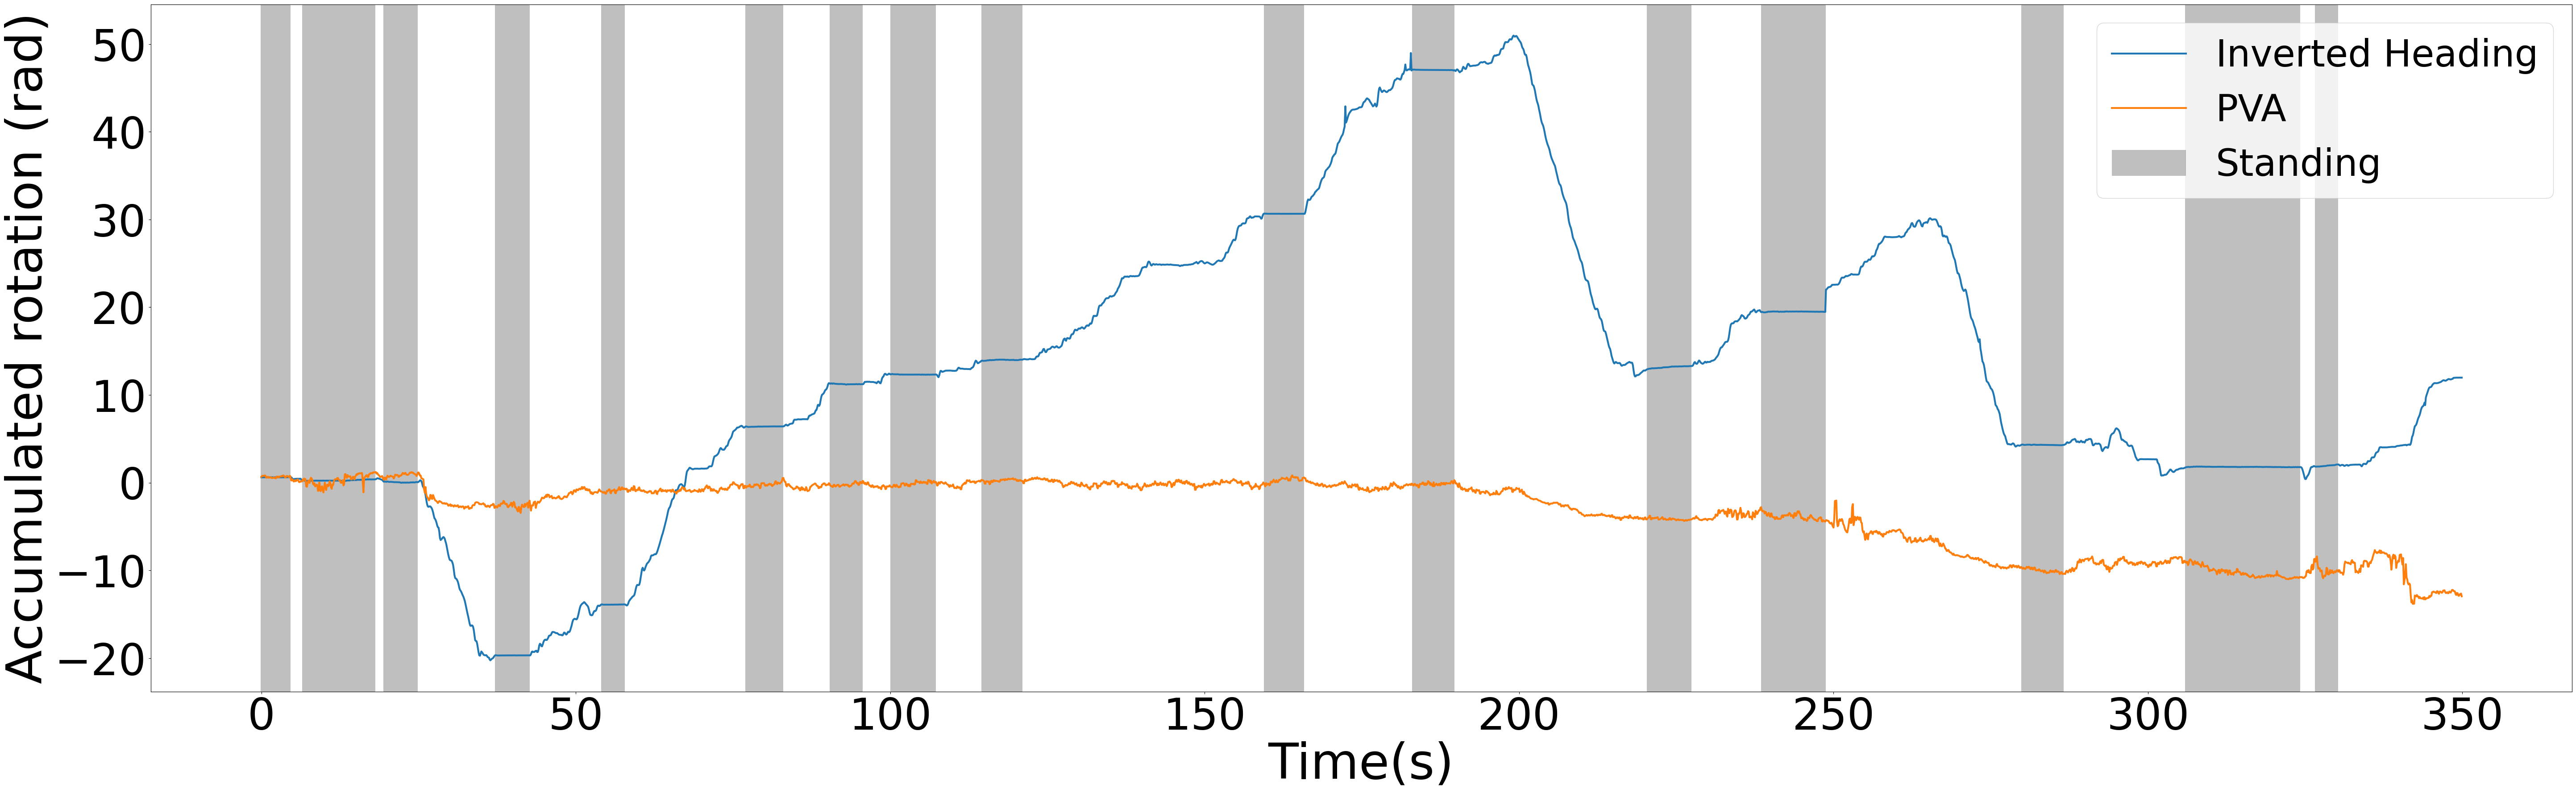

In [65]:
#find stop period and plot as shaded under unwrapped PVA/behavior
persistence_stop_index_and_length = find_stop_period_on_heading(head_velocity_array = Angular_velocity,degree_of_tolerance =15,shortest_stopFrame=int(np.ceil(3/volume_time)))
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,Unwrapped_heading ,linewidth =3)
plt.plot(time_array_imaging, PVA_Unwrapped_Radian,linewidth =3)
#plt.plot(time_array_imaging, Forward_speed_radian,linewidth =3)
plt.xlabel('Time(s)', fontsize=80)
plt.ylabel('Accumulated rotation (rad)', fontsize=80)

#Plot calculated standing period under shaded area
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
if trial_type == 0:
    plt.legend(['Inverted Heading','PVA','Standing'],fontsize=60)
else:
    plt.legend(['Bar Position','PVA','Standing'],fontsize=60)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
#plt.grid()
plt.show()

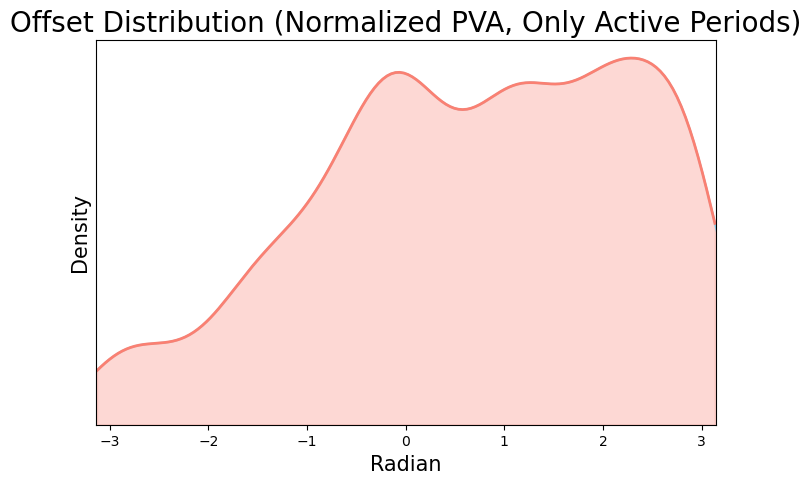

In [66]:
radian_offset_normalized = offset_calculation(Wrapped_heading, PVA_Radian, IfRadian = True)
# Bump offset excluding low velocity point
radian_offset_no_stopping_period_normalized = []
for i in range(len(Angular_velocity_no_series)):
    if np.abs(Angular_velocity_no_series[i]) >= 0.26:
        radian_offset_no_stopping_period_normalized.append(radian_offset_normalized[i])

        # Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Use Seaborn to create a kernel density estimate plot with shaded area under the curve
kde_values = sns.kdeplot(radian_offset_no_stopping_period_normalized, fill=False, color='skyblue').get_lines()[0].get_data()

# Extract values within the desired range
x_values_within_range = kde_values[0][(kde_values[0] >= -np.pi) & (kde_values[0] <= np.pi)]
y_values_within_range = kde_values[1][(kde_values[0] >= -np.pi) & (kde_values[0] <= np.pi)]

# Customize plot labels and title
ax.set_title('Offset Distribution (Normalized PVA, Only Active Periods)', fontsize=20)
ax.set_xlabel('Radian', fontsize=15)
ax.set_ylabel('Density', fontsize=15)

# Plot the KDE within the specified range
ax.plot(x_values_within_range, y_values_within_range, color='salmon', linewidth=2)

# Shade the area under the curve
ax.fill_between(x_values_within_range, y_values_within_range, color='salmon', alpha=0.3)

# Set x-axis limits to be within -π to π
ax.set_xlim([-np.pi, np.pi])

# Remove y-axis ticks for a cleaner look
ax.set_yticks([])

# Display the plot
plt.show()

In [67]:
PVA_radian_array_normalized_offset = moving_wrapped_plot_by_offset(PVA_Radian,math.degrees(0), ifRadian =True)

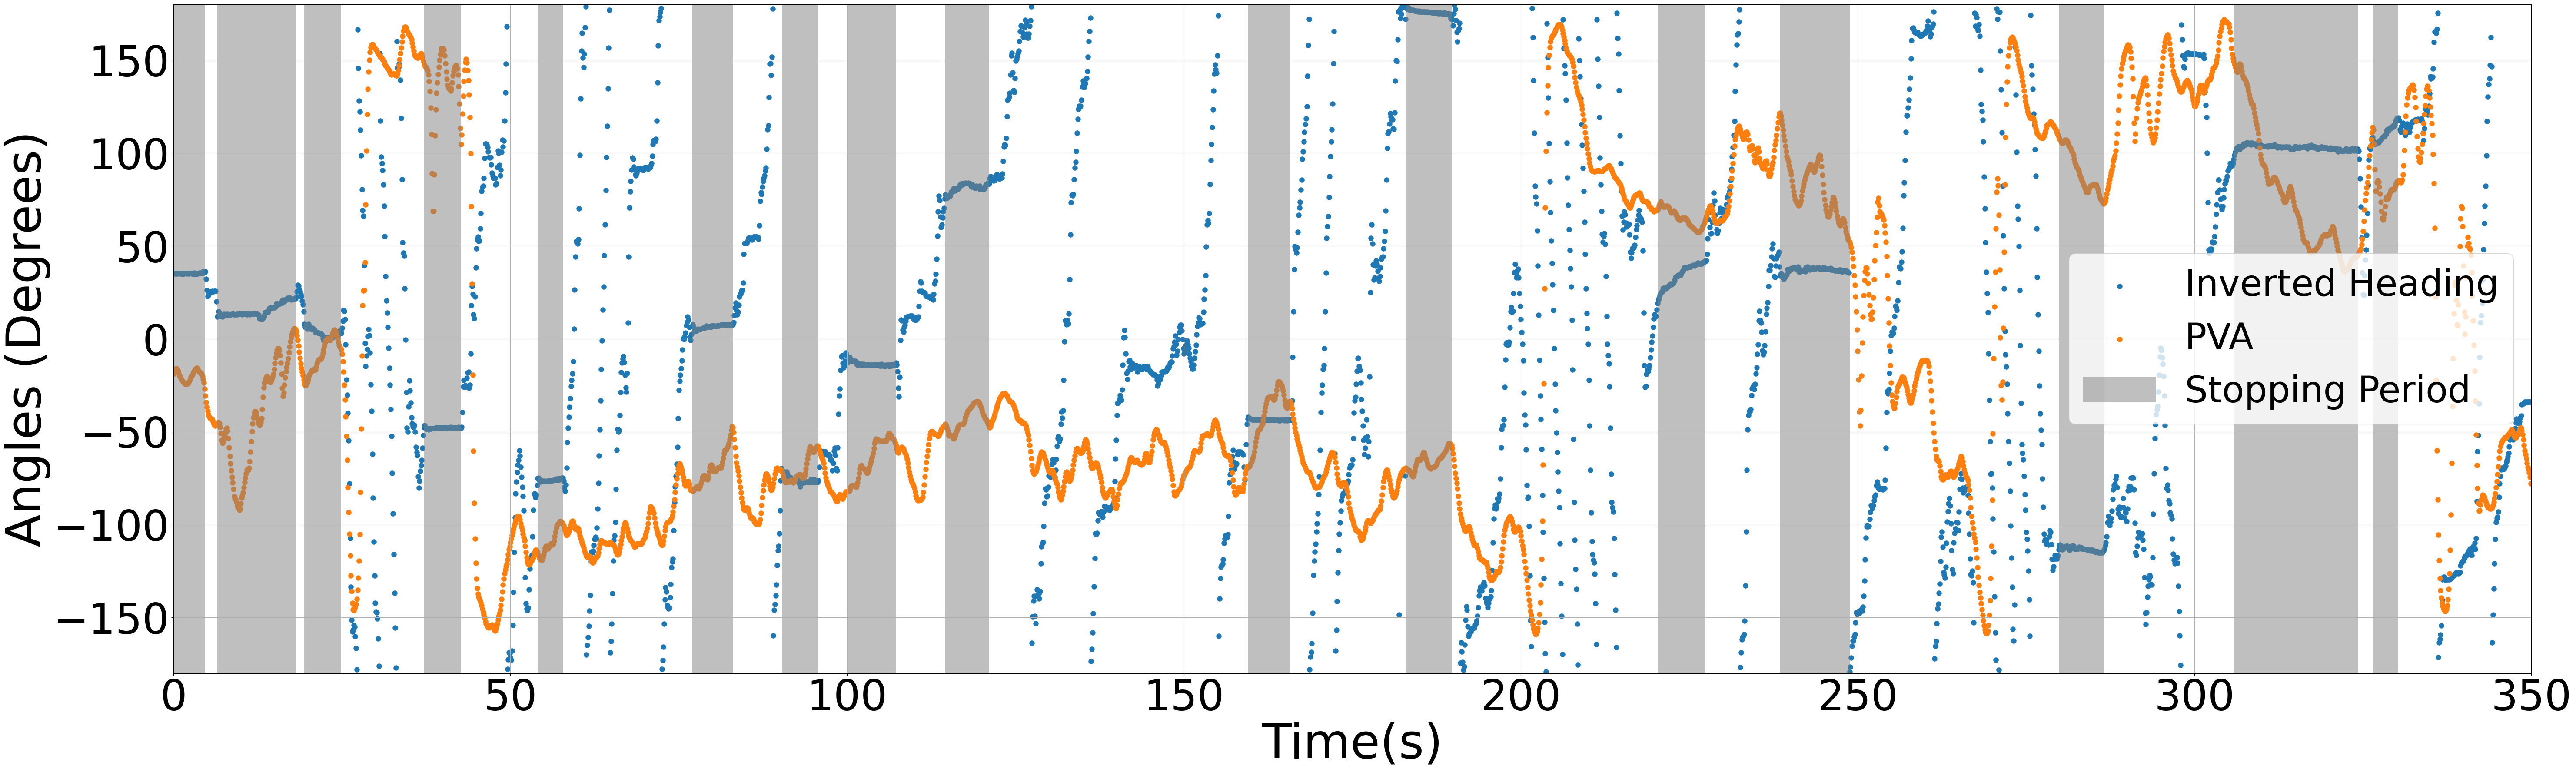

In [68]:
#Plot the stoping period as shaded under wrapped behavior
b = plt.figure(figsize= (70,20))
PVA_radian_array_normalized_offset_filtered = low_pass_filter_TQ(PVA_radian_array_normalized_offset,0.5,volume_rate)
PVA_radian_array_normalized_offset_filtered_angle = PVA_radian_to_angle(PVA_radian_array_normalized_offset_filtered)
Wrapped_heading_angle = PVA_radian_to_angle(Wrapped_heading )

plt.scatter(time_array_imaging,Wrapped_heading_angle ,linewidth =3)
plt.scatter(time_array_imaging,PVA_radian_array_normalized_offset_filtered_angle, linewidth = 3)
plt.xlabel('Time(s)', fontsize=80)
plt.xlabel('Time(s)', fontsize=80)
plt.ylabel('Angles (Degrees)', fontsize=80)

#Plot calculated standing period under shaded area
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
if trial_type == 0:
    plt.legend(['Inverted Heading','PVA','Stopping Period'],fontsize=60)
    #plt.legend(['Heading','Neural Angle','Stopping Period'],fontsize=60)
else:
    plt.legend(['Bar Position','PVA','Stopping Period'],fontsize=60, loc = 4)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylim(-180, 180)
plt.grid()
plt.show()
#b.savefig('Behavior_trace_with_PVA_delta7', format ='svg')

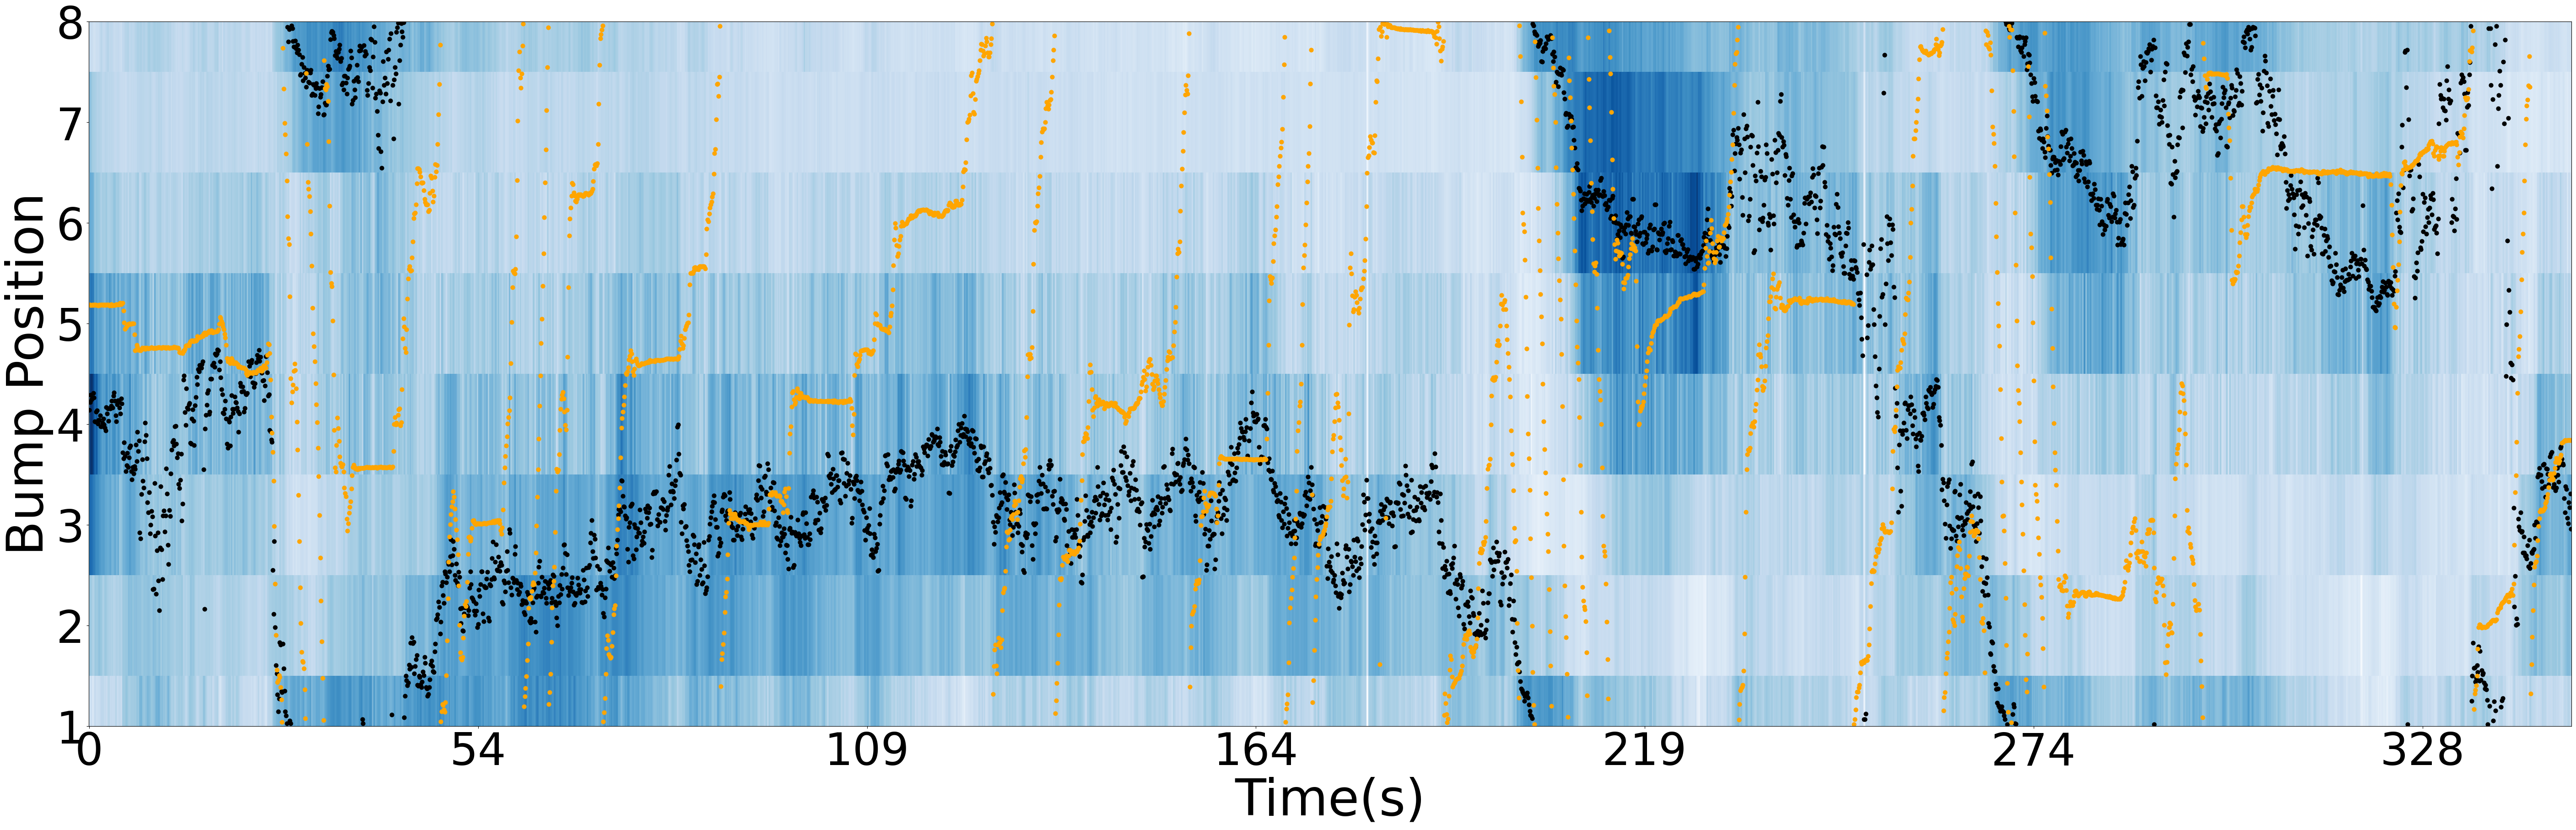

In [69]:
df_dff_in_ROI_normalized = dff_normalized_8_roi.transpose()
df_dff_in_ROI_normalized_shifted = np.zeros((np.size(df_dff_in_ROI_normalized,0),np.size(df_dff_in_ROI_normalized,1)))
df_dff_in_ROI_normalized_shifted[0,:] = df_dff_in_ROI_normalized[4,:]
df_dff_in_ROI_normalized_shifted[1,:] = df_dff_in_ROI_normalized[5,:]
df_dff_in_ROI_normalized_shifted[2,:] = df_dff_in_ROI_normalized[6,:]
df_dff_in_ROI_normalized_shifted[3,:] = df_dff_in_ROI_normalized[7,:] 
df_dff_in_ROI_normalized_shifted[4,:] = df_dff_in_ROI_normalized[0,:] 
df_dff_in_ROI_normalized_shifted[5,:] = df_dff_in_ROI_normalized[1,:] 
df_dff_in_ROI_normalized_shifted[6,:] = df_dff_in_ROI_normalized[2,:] 
df_dff_in_ROI_normalized_shifted[7,:] = df_dff_in_ROI_normalized[3,:] 
a=plt.figure(figsize= (70,20))
plt.imshow(df_dff_in_ROI_normalized_shifted, aspect= 'auto', interpolation = 'none', cmap = 'Blues')
#plt.imshow(df_dff_in_ROI_normalized_shifted, aspect= 'auto', cmap = 'Blues')
plt.xlabel('Time(s)', fontsize=80)
plt.ylabel('Bump Position', fontsize=80)
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]/volume_rate, dtype=np.int64), fontsize =70)
plt.yticks(ticks=plt.yticks()[0][0:], labels=np.array(plt.yticks()[0][0:]+1, dtype=np.int64), fontsize=70)
plt.ylim(0,7)
plt.locator_params(axis ='x',nbins = 20)
plt.scatter(np.arange(len(PVA_Angle)),7*(PVA_Angle+180)/2/180, color ='black', s = 40)
if trial_type == 1:
    plt.scatter(np.arange(len(Wrapped_heading_angle)),7*(Wrapped_heading_angle+180)/2/180, color ='red', s = 40)
if trial_type == 0:
    plt.scatter(np.arange(len(Wrapped_heading_angle)),7*(Wrapped_heading_angle+180)/2/180, color ='orange', s = 40)    
plt.show()
#a.savefig('delta7_Bump_Heatmap__dark', format ='svg')

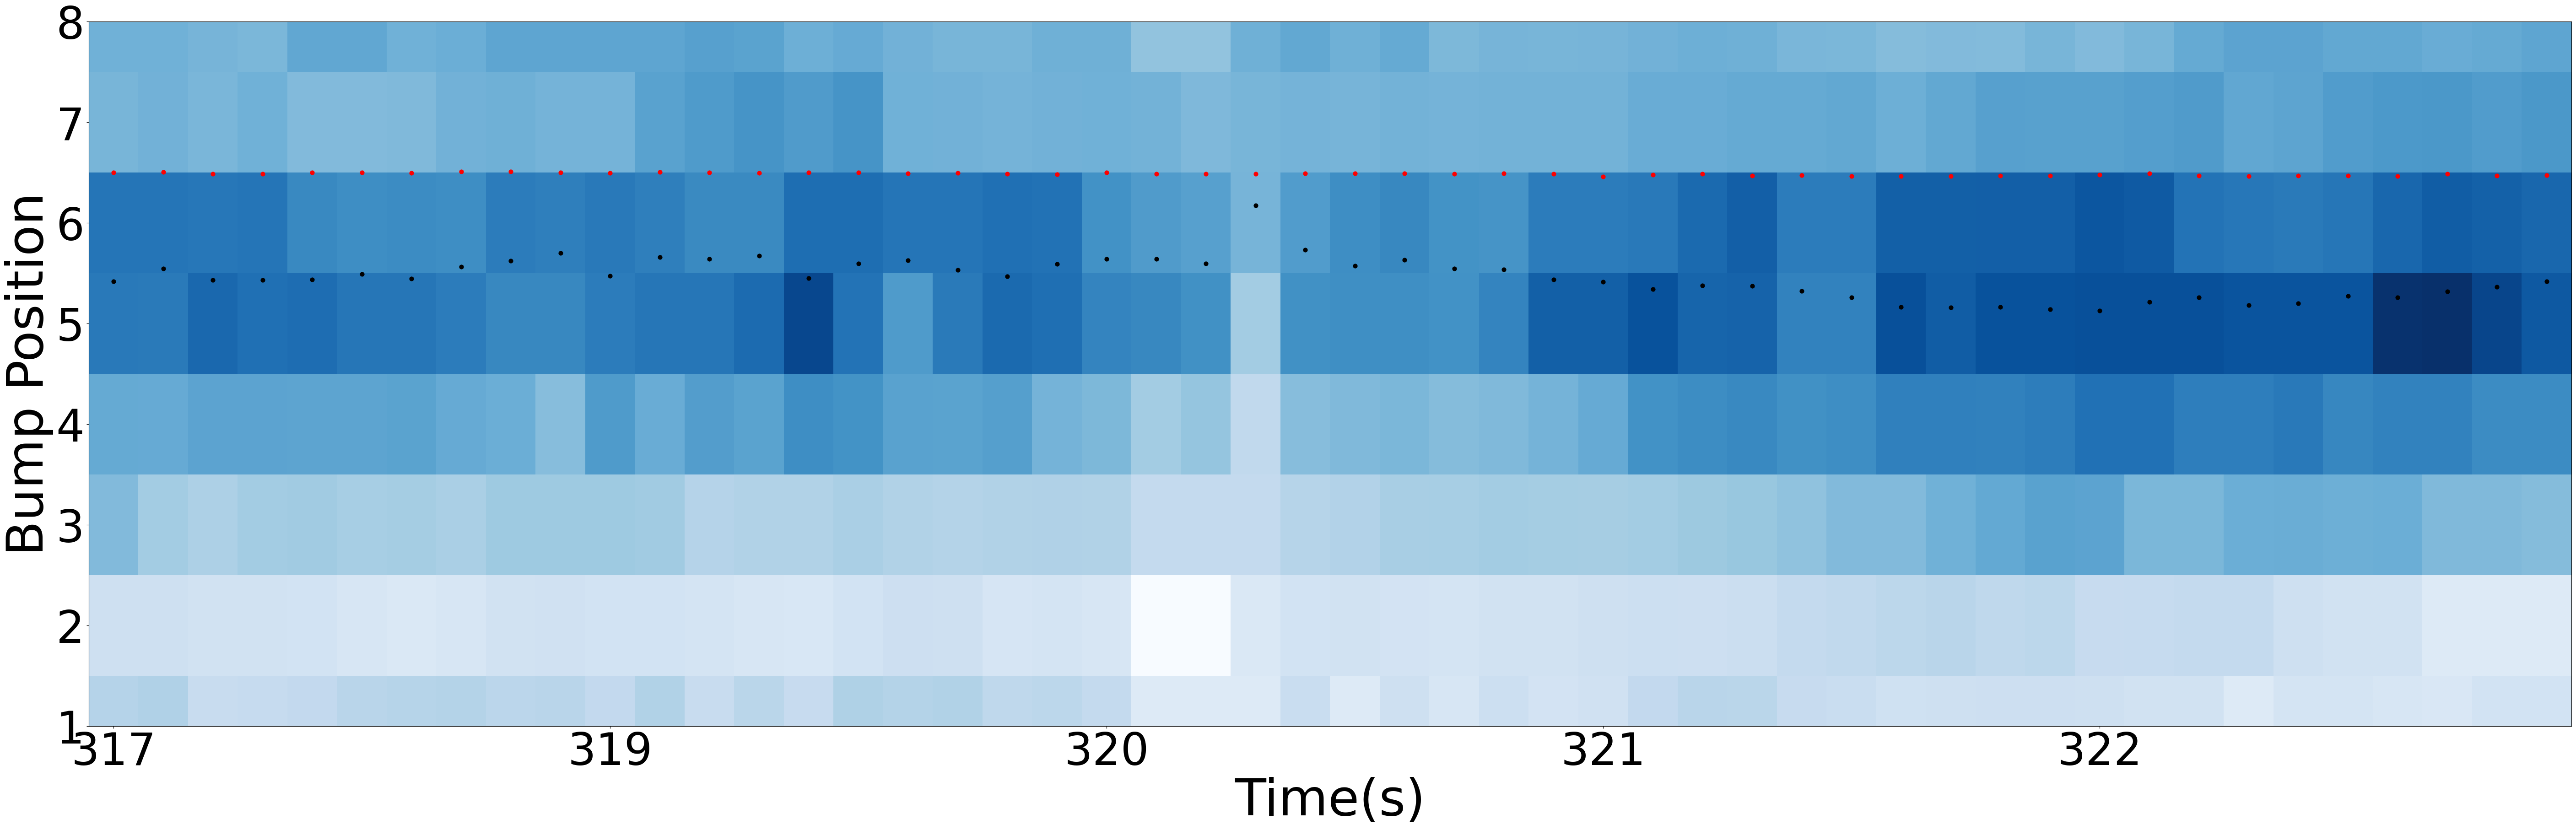

In [89]:
range_start = 2900
range_end = 2950
a=plt.figure(figsize= (70,20))
plt.imshow(df_dff_in_ROI_normalized_shifted[:,range_start:range_end], aspect= 'auto', interpolation = 'none', cmap = 'Blues')
plt.xlabel('Time(s)', fontsize=80)
plt.ylabel('Bump Position', fontsize=80)
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]/volume_rate+ range_start*volume_time, dtype=np.int64), fontsize =70)
plt.yticks(ticks=plt.yticks()[0][0:], labels=np.array(plt.yticks()[0][0:]+1, dtype=np.int64), fontsize=70)
plt.ylim(0,7)
plt.locator_params(axis ='x',nbins = 20)
plt.scatter(np.arange(len(PVA_Angle[range_start:range_end])),7*(PVA_Angle[range_start:range_end]+180)/2/180, color ='black', s = 40)
plt.scatter(np.arange(len(Wrapped_heading_angle[range_start:range_end])),7*(Wrapped_heading_angle[range_start:range_end]+180)/2/180, color ='red', s = 40)
plt.show()

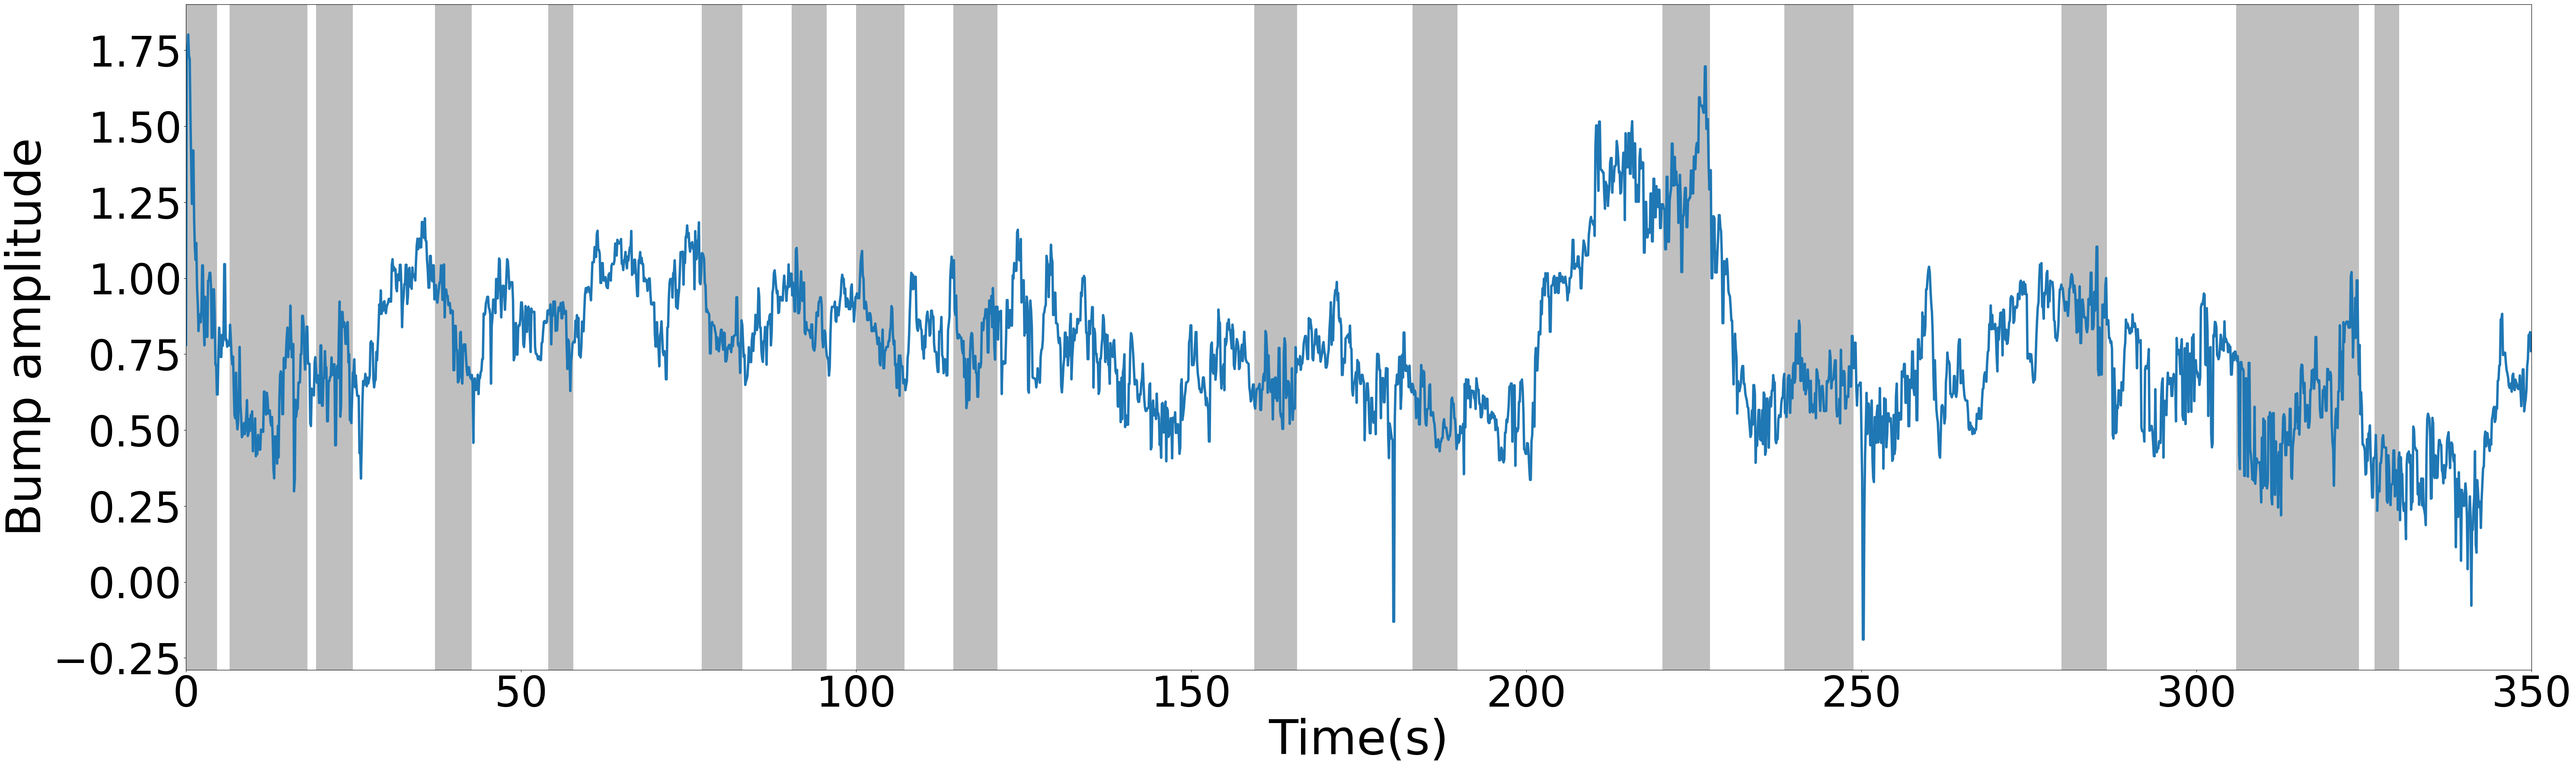

In [90]:
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,bump_amplitude_dff_normalized_v3,linewidth =4)
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('Bump amplitude', fontsize=80)
plt.show()

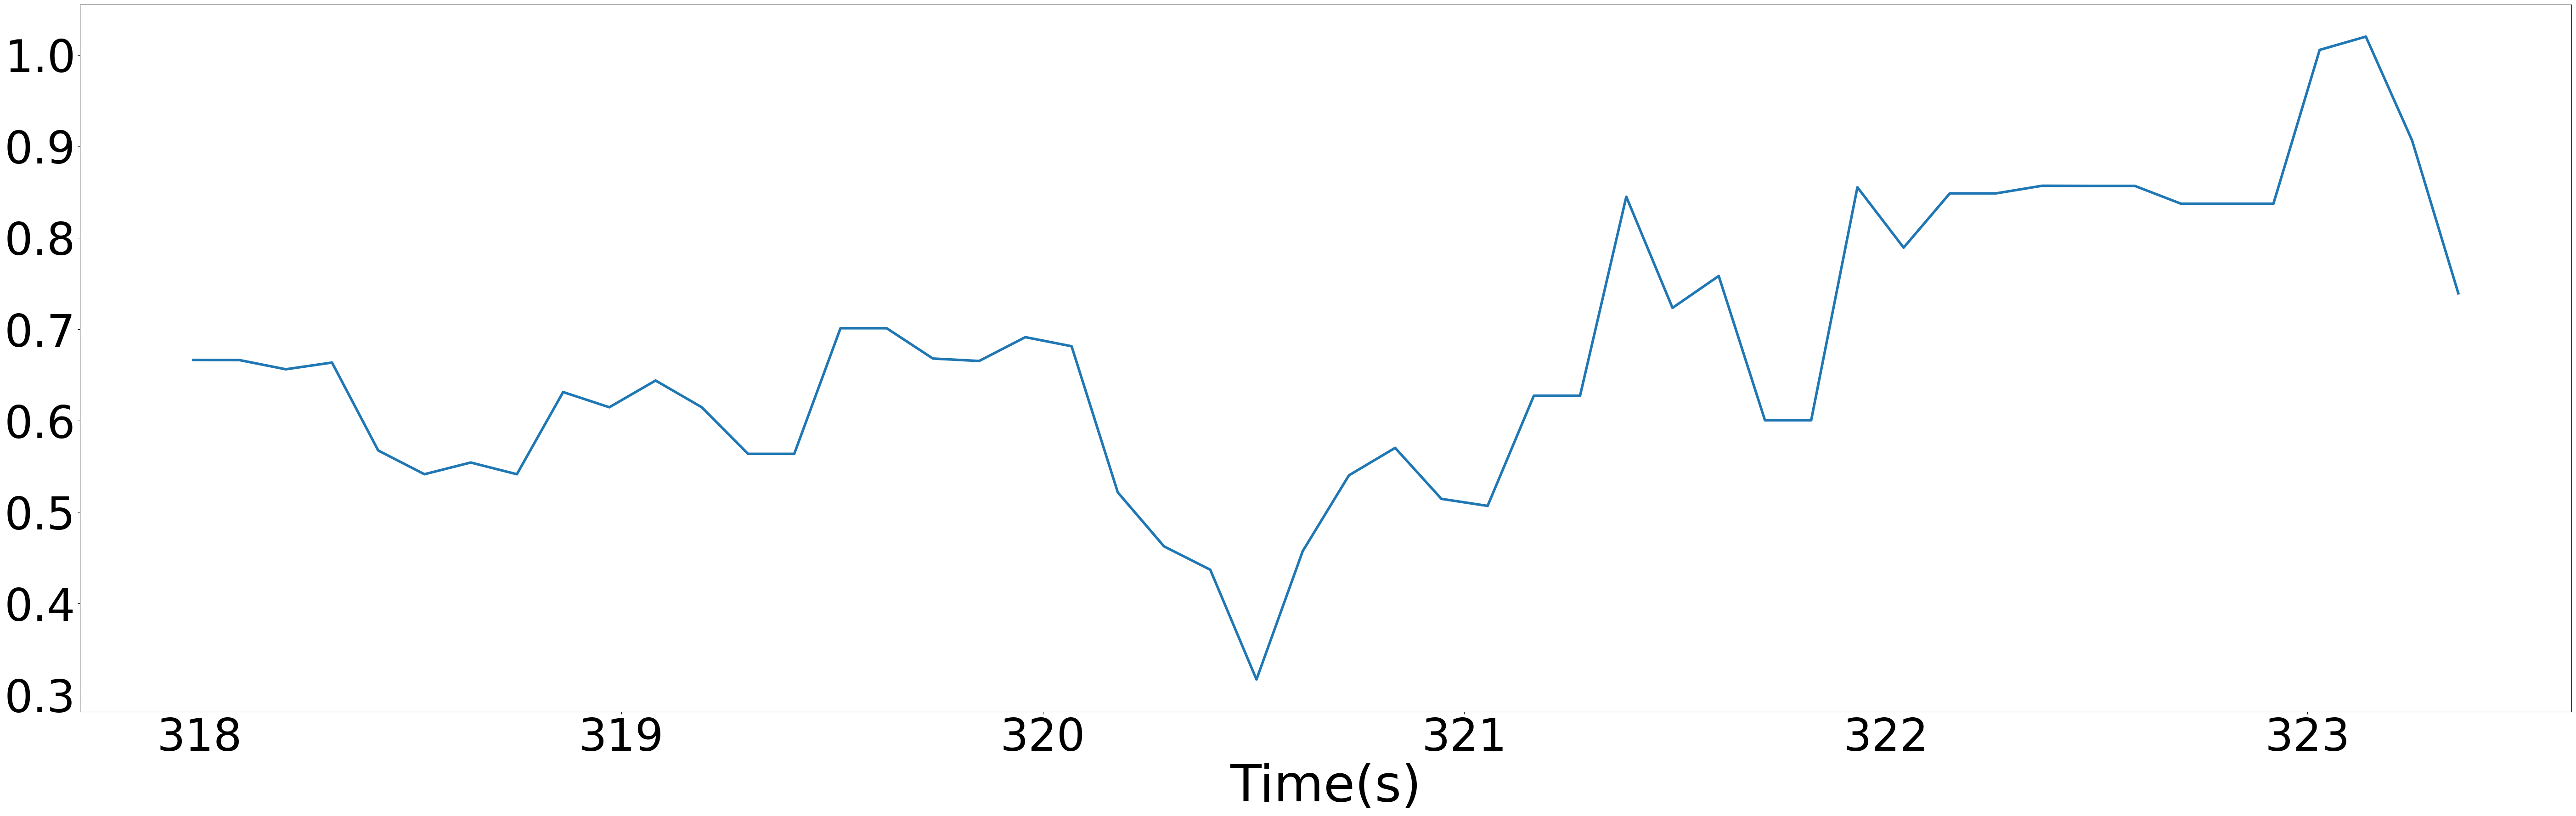

In [91]:
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging[2900:2950],bump_amplitude_dff_normalized_v3[2900:2950],linewidth =4)
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.show()

In [92]:
bump_amplitude_dff_normalized_v3[350:400]

array([0.92857955, 1.04527459, 0.87086739, 0.96250774, 0.96250774,
       0.94206513, 0.94206513, 0.91079233, 0.91356127, 0.91826442,
       0.88434749, 0.89531441, 0.8921258 , 0.8921258 , 0.69714104,
       0.69714104, 0.8429664 , 0.8429664 , 0.76352517, 0.76352517,
       0.65699244, 0.66071499, 0.67658202, 0.82034902, 0.82308981,
       0.67971747, 0.65309647, 0.77391788, 0.78205916, 0.76235856,
       0.78204074, 0.73989093, 0.70088397, 0.68065034, 0.70673768,
       0.70673768, 0.68496074, 0.67221828, 0.66829077, 0.68151819,
       0.65217593, 0.45787232, 0.64365977, 0.6702827 , 0.63196717,
       0.63196717, 0.64726178, 0.6822851 , 0.61830987, 0.66771529])

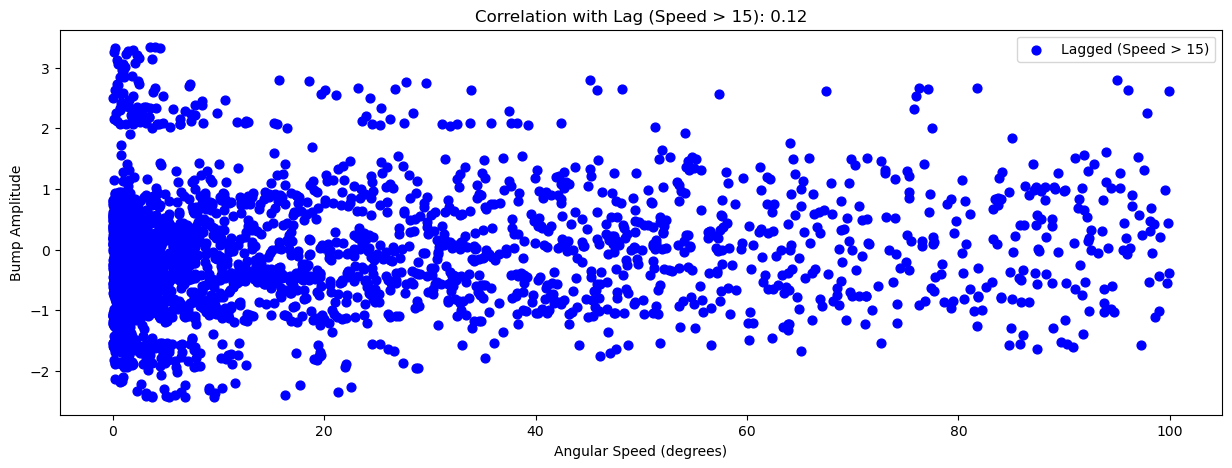

In [93]:
from scipy.signal import correlate

Bump_amplitude_smooth_for_speed_cor = gaussian_filter1d(bump_amplitude_dff_normalized_v3, sigma =6)
Bump_amplitude_z_smooth_for_speed_cor = zscore(Bump_amplitude_smooth_for_speed_cor)


# Calculate cross-correlation within the allowed lags range
cross_corr = correlate(angular_speed_degrees, Bump_amplitude_z_smooth_for_speed_cor, mode='full')
lags = correlation_lags(angular_speed_degrees.size,  Bump_amplitude_z_smooth_for_speed_cor.size, mode="full")
                                  
#find the middle index to consider the frame on both side till max shift frame (1s)
max_shift_frame = int(volume_rate)
middle_index = int(len(lags)/2)
lags_short = lags[(middle_index - max_shift_frame):(middle_index + max_shift_frame + 1) ]
correlation_short = cross_corr[(middle_index - max_shift_frame):(middle_index + max_shift_frame + 1) ]
lag = lags_short[np.argmax(correlation_short)]
if lag > 0:
    lag = lags_short[np.argmax(correlation_short[0:int((len(correlation_short)-1)/2+1)])]
lag = int(-0.4/volume_time)
    
# Apply the lag only to Bump_amplitude_z_smooth_for_speed_cor
    
#shift back tne bump_amplitude by drop the lag frame at the beginning
lagged_Bump_amplitude_z_smooth_for_speed_cor = Bump_amplitude_z_smooth_for_speed_cor[-lag:]
angular_speed_degrees_shifted = angular_speed_degrees[:len(lagged_Bump_amplitude_z_smooth_for_speed_cor)]
# Create a mask for data points where Forward_speed_degrees > 15
mask = (angular_speed_degrees_shifted > 0) & (angular_speed_degrees_shifted < 100)

# Apply the mask to both time series
masked_angular_speed = angular_speed_degrees_shifted[mask]
masked_lagged_Bump_amplitude_z_smooth_for_speed_cor = lagged_Bump_amplitude_z_smooth_for_speed_cor[mask]

# Now you can calculate the correlation with lag accounted for and the mask
correlation_coefficient = np.corrcoef(masked_angular_speed, masked_lagged_Bump_amplitude_z_smooth_for_speed_cor)[0, 1]

# Plot the original and lagged time series for visualization
plt.figure(figsize=(15, 5))
plt.scatter(masked_angular_speed, masked_lagged_Bump_amplitude_z_smooth_for_speed_cor, color='blue', s=40, label='Lagged (Speed > 15)')
plt.legend()
plt.xlabel('Angular Speed (degrees)')
plt.ylabel('Bump Amplitude')
plt.title(f'Correlation with Lag (Speed > 15): {correlation_coefficient:.2f}')
plt.show()

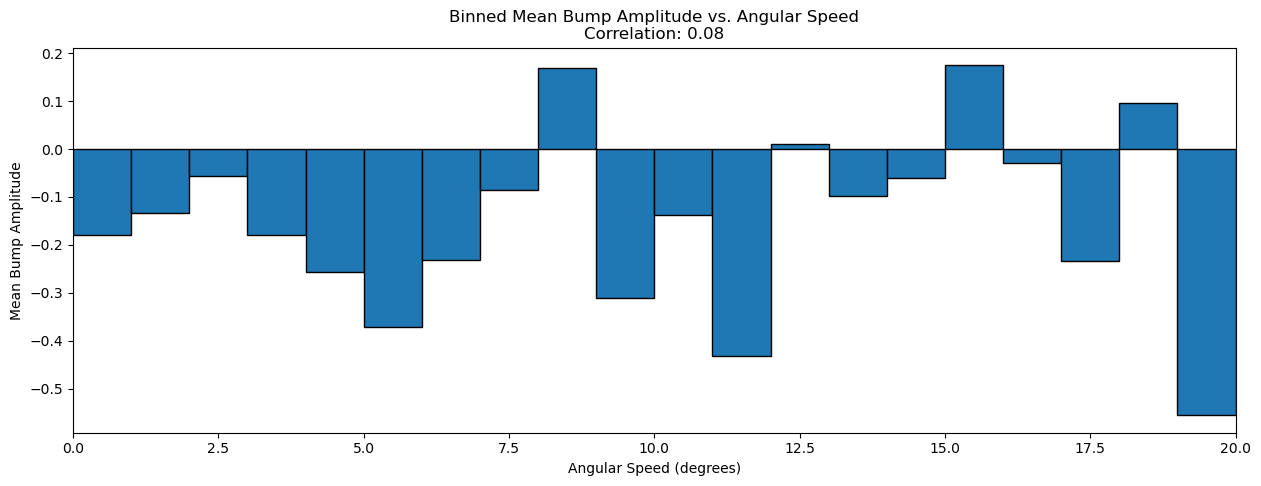

In [94]:


# Define the bin edges with a bin width of 5
bin_width = 1
bin_edges = np.arange(0, 20 + bin_width, bin_width)

# Use scipy's binned_statistic to calculate the mean bump amplitude for each bin
binned_stats = binned_statistic(angular_speed_degrees_shifted, lagged_Bump_amplitude_z_smooth_for_speed_cor, statistic='mean', bins=bin_edges)

# Extract the mean bump amplitude and bin centers
mean_bump_amplitude_per_bin = binned_stats.statistic
bin_centers = binned_stats.bin_edges[:-1] + 0.5 * bin_width

# Exclude bins with no data points
valid_bins = ~np.isnan(mean_bump_amplitude_per_bin)

# Calculate the correlation between mean bump amplitude and bin centers for valid bins
correlation_coefficient = np.corrcoef(bin_centers[valid_bins], mean_bump_amplitude_per_bin[valid_bins])[0, 1]

# Plot the binned mean bump amplitude against the angular speed for valid bins
plt.figure(figsize=(15, 5))
plt.bar(bin_centers[valid_bins], mean_bump_amplitude_per_bin[valid_bins], width=bin_width, align='center', edgecolor='black')
plt.xlim(0, np.max(bin_edges))  # Set the limit for angular speed
plt.xlabel('Angular Speed (degrees)')
plt.ylabel('Mean Bump Amplitude')
plt.title(f'Binned Mean Bump Amplitude vs. Angular Speed\nCorrelation: {correlation_coefficient:.2f}')
plt.show()

In [95]:
bin_centers

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
       11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5])

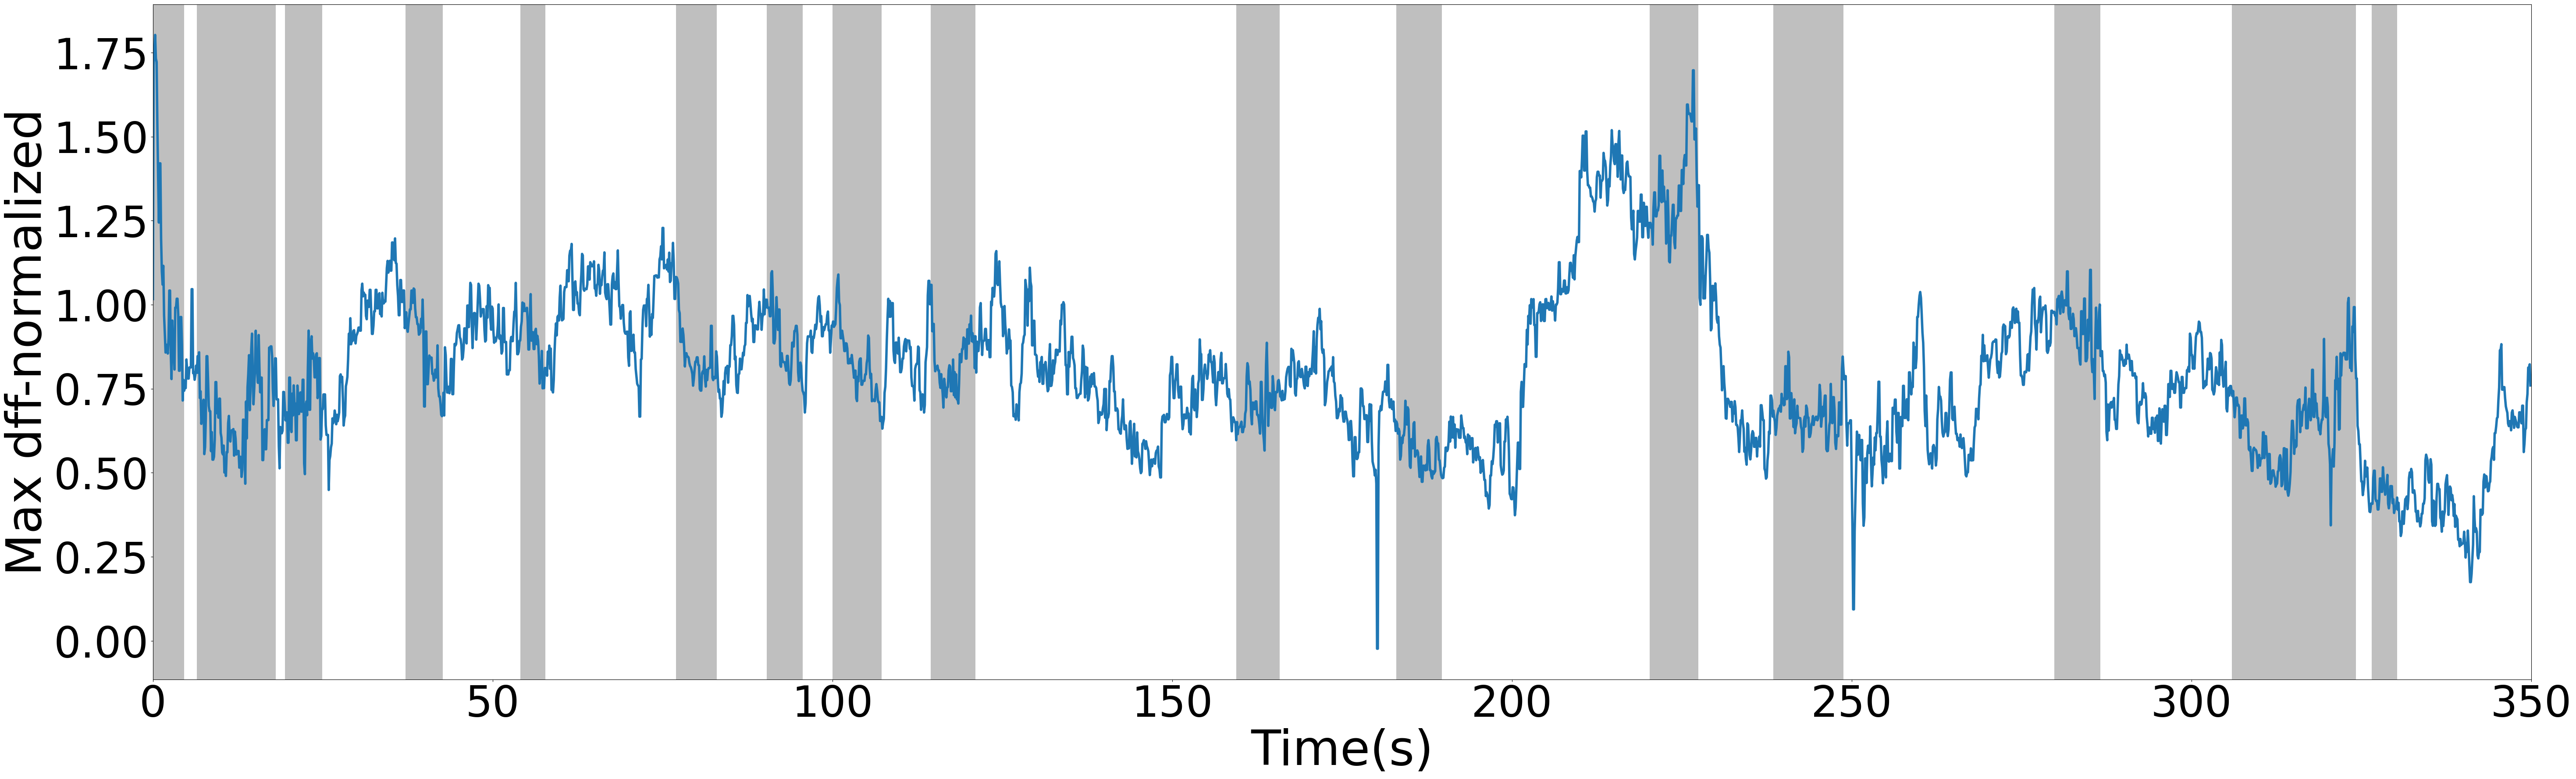

In [96]:
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,np.max(dff_normalized_8_roi,axis=1),linewidth =4)
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('Max dff-normalized', fontsize=80)
plt.show()
plt.show()

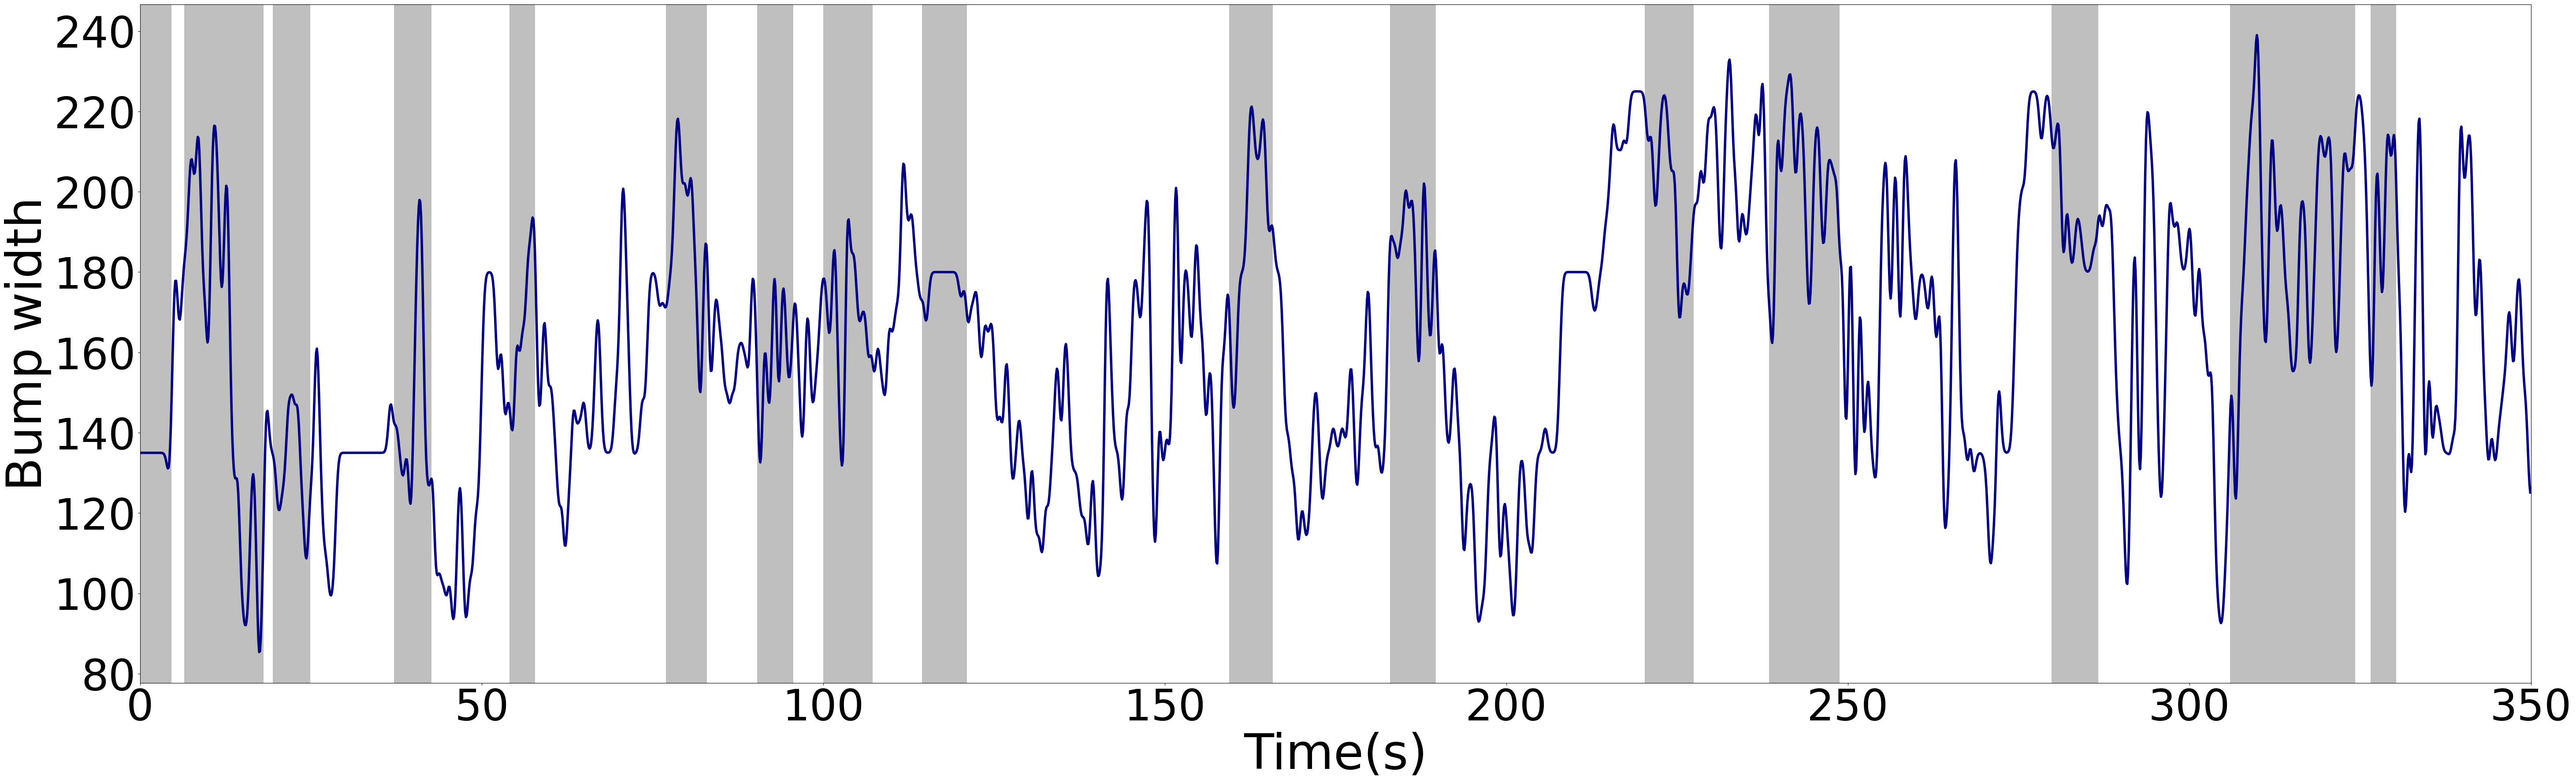

In [97]:
bump_width= calculateBumpWidth_v1(dff_normalized_8_roi,8)
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,gaussian_filter1d(bump_width, sigma =3),linewidth =4, color ='navy')
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('Bump width', fontsize=80)
plt.show()
plt.show()

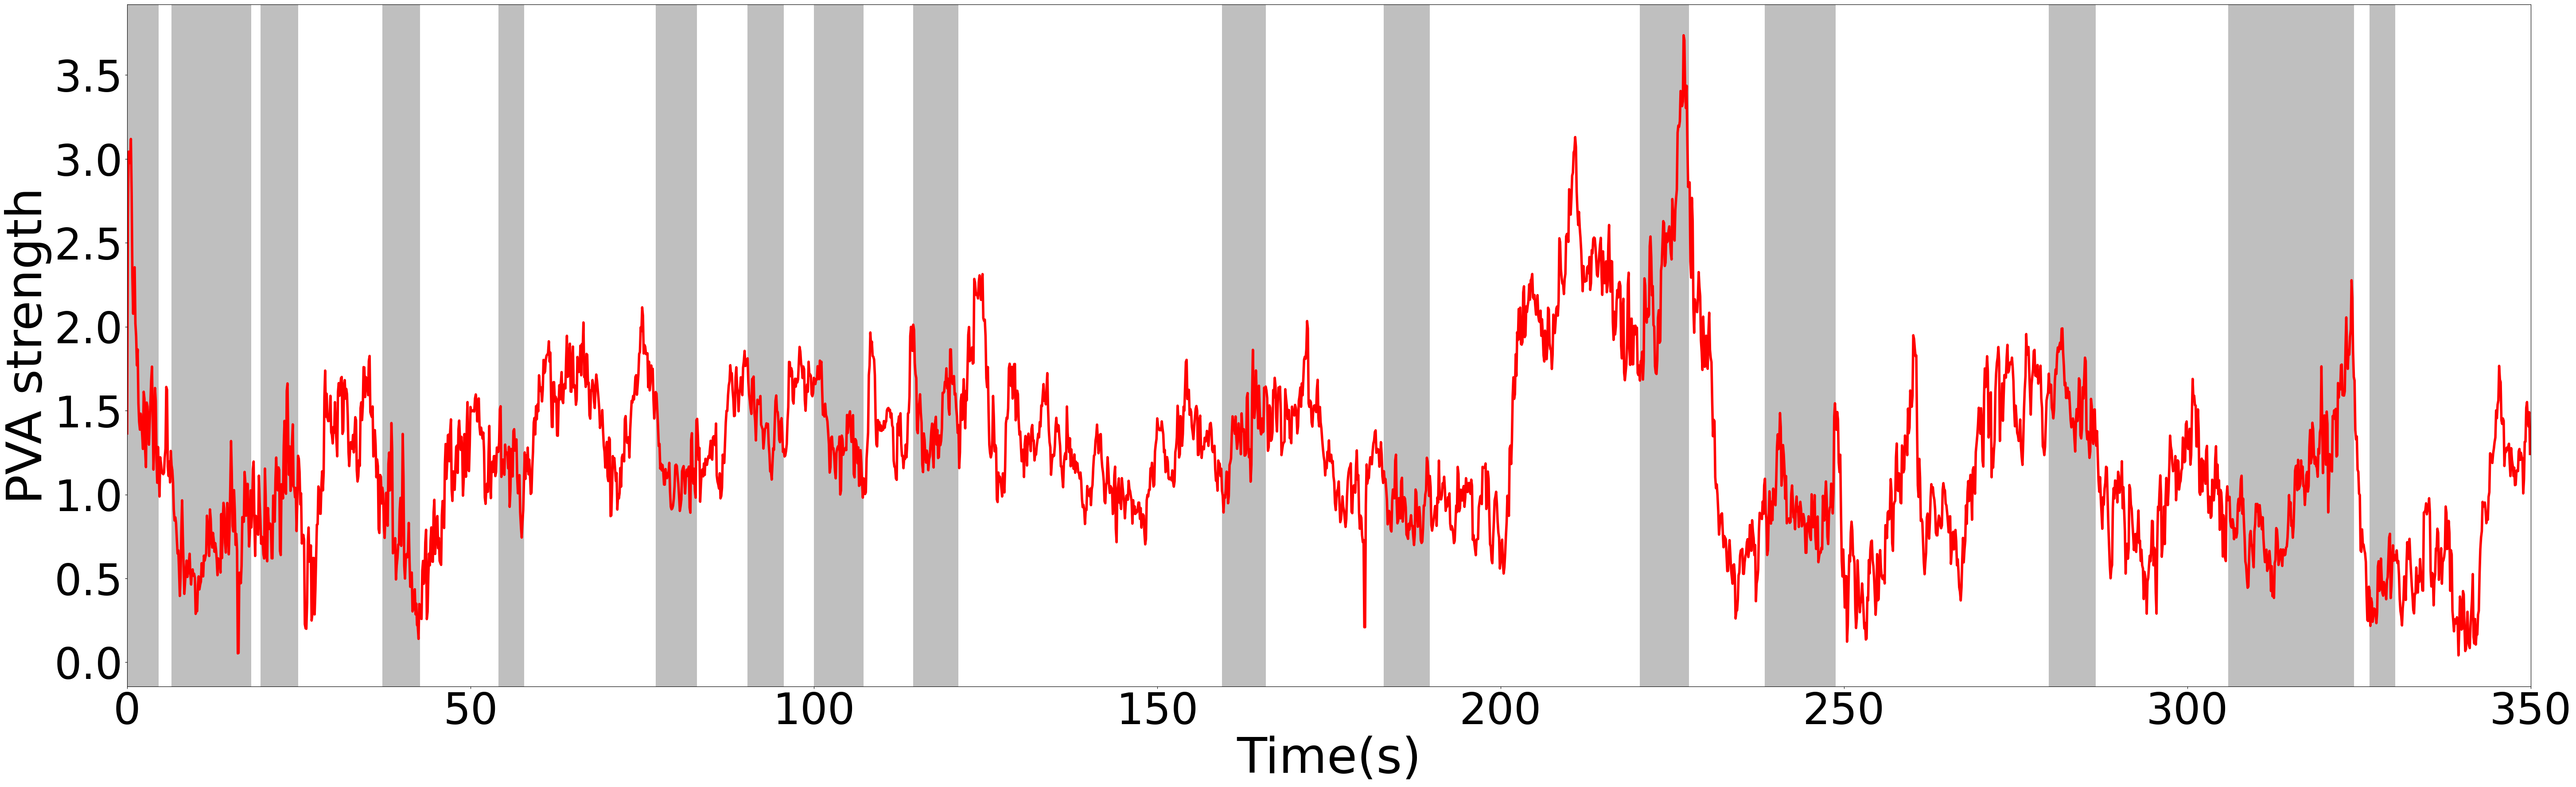

In [98]:
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,PVA_strength_no_series,color = 'r',linewidth =4)
#plt.plot(time_array_imaging,PVA_strength_no_series,color = 'b',linewidth =4)
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('PVA strength', fontsize=80)
plt.show()

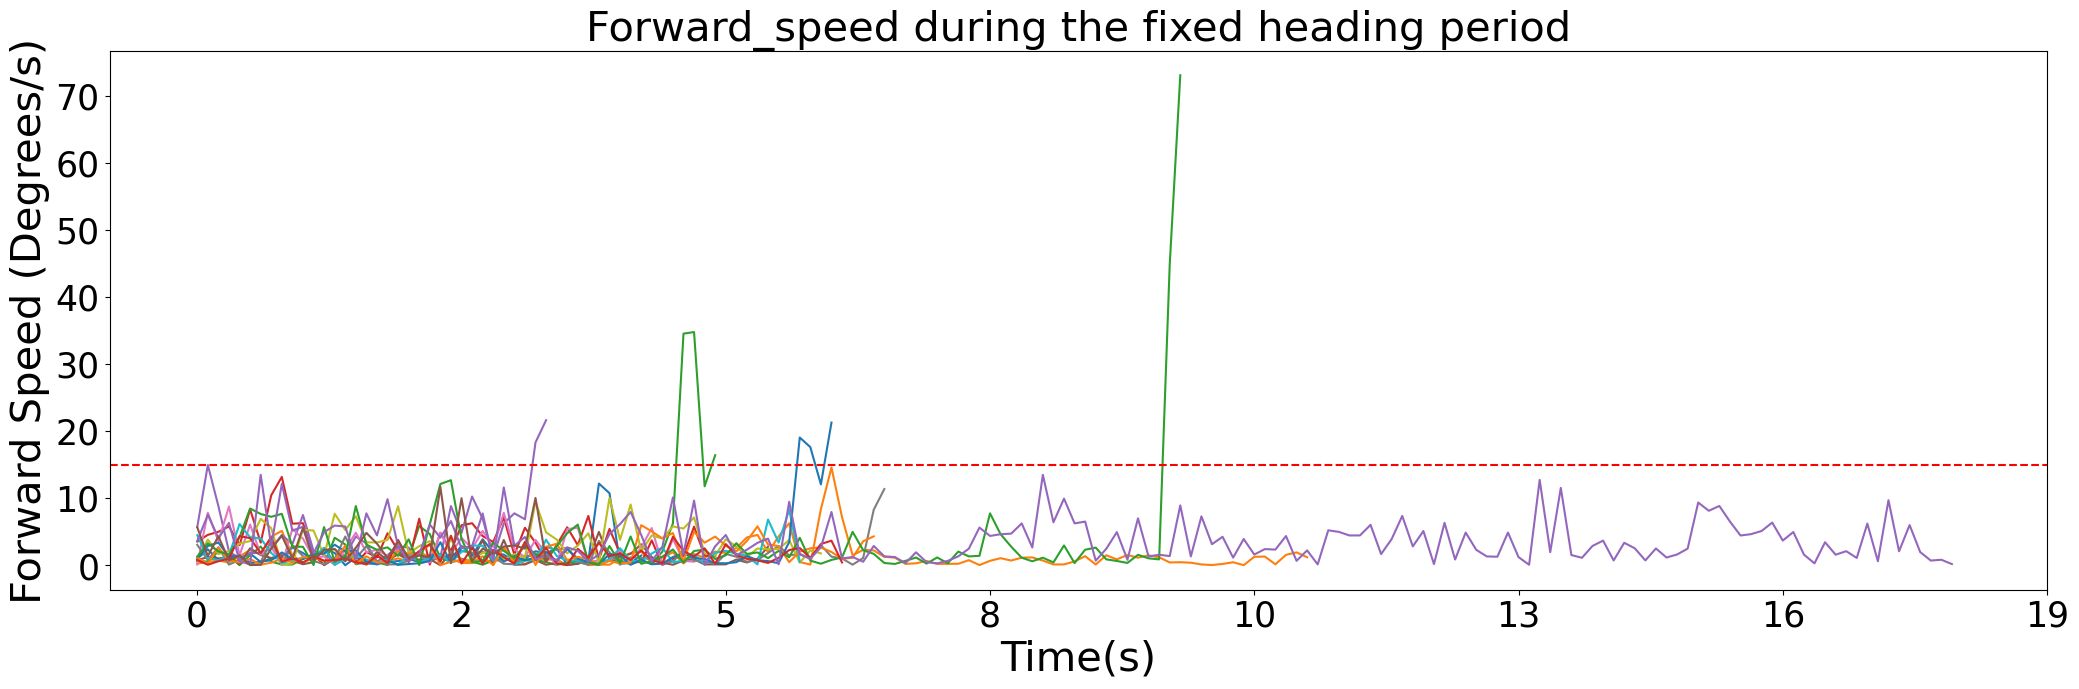

In [99]:
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(Forward_speed_degrees[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1])
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=25)
plt.title('Forward_speed during the fixed heading period', fontsize =30)
plt.axhline(y= 15, color = 'r',linestyle ='--')
plt.xlabel('Time(s)', fontsize=30)
plt.yticks(fontsize=25)
plt.ylabel('Forward Speed (Degrees/s)', fontsize=30)
plt.show()
    

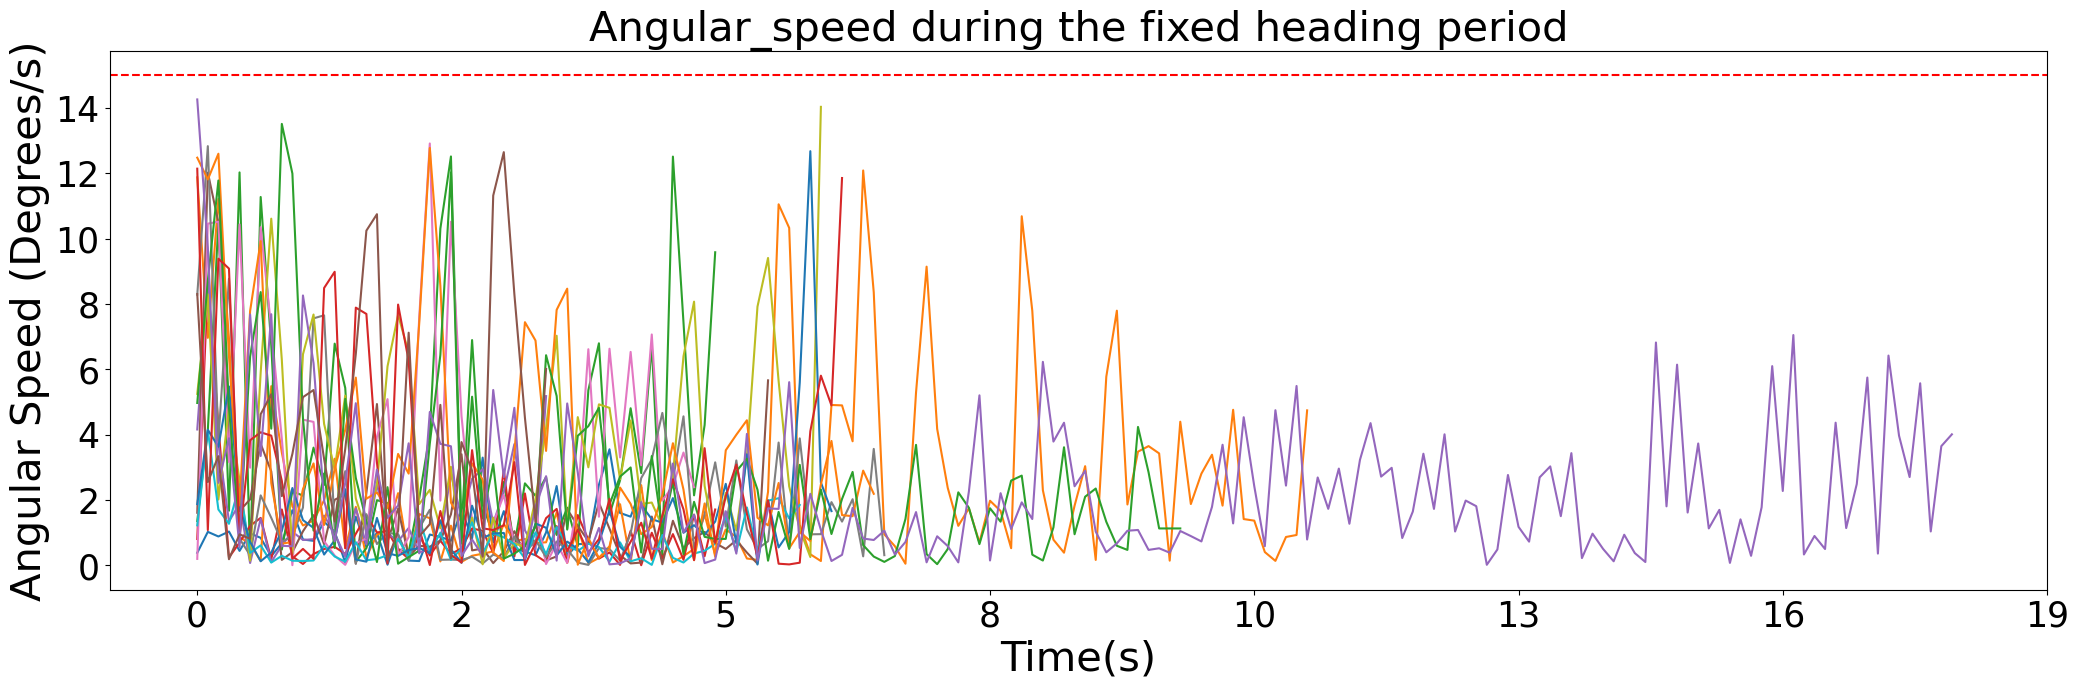

In [100]:
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(angular_speed_degrees[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1])
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=25)
plt.title('Angular_speed during the fixed heading period', fontsize =30)
plt.axhline(y= 15, color = 'r',linestyle ='--')
plt.xlabel('Time(s)', fontsize=30)
plt.yticks(fontsize=25)
plt.ylabel('Angular Speed (Degrees/s)', fontsize=30)
plt.show()
    

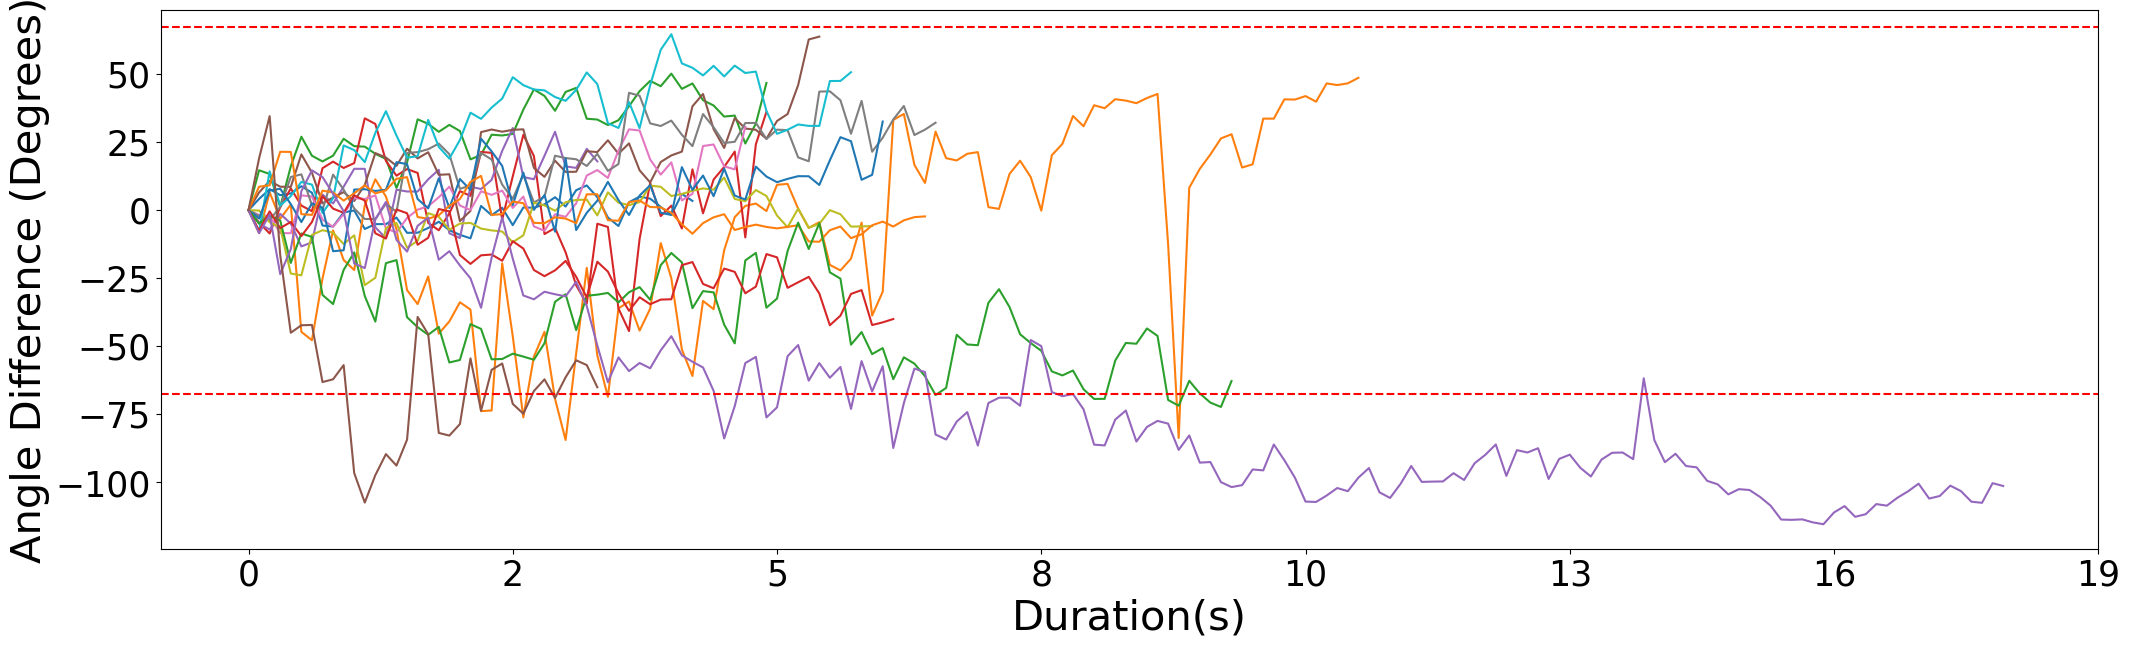

In [101]:
#Calculate annd plot difference throughout the stop period
difference_during_stop = []
current_difference_during_stop = []
current_forward_speed_during_stop = []
forward_speed_during_stop =[]
plt.figure(figsize= (25,7))
for current_index in range(len(persistence_stop_index_and_length)):
    current_stop_PVA = PVA_Angle_no_series[persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1]
    current_stop_start_index = persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1
    current_difference_during_stop = PVA_Angle_no_series[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1] - current_stop_PVA
    current_forward_speed_during_stop = Forward_speed_degrees[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1]
    #Modify the value so angle difference will never be different more than 180 degrees
    for j in range(len(current_difference_during_stop)):
        if np.abs(current_difference_during_stop[j]) > 180:
            if current_difference_during_stop[j] < 0:
                current_difference_during_stop[j] =  current_difference_during_stop[j] + 360
            else:
                current_difference_during_stop[j] =  current_difference_during_stop[j] - 360
    
    difference_during_stop.append(current_difference_during_stop)
    forward_speed_during_stop.append(current_forward_speed_during_stop)
    plt.plot(current_difference_during_stop)

max_length = 0
for i in range(len(difference_during_stop)):
    if max_length < len(difference_during_stop[i]):
        max_length = len(difference_during_stop[i])

time_array_PVA_difference_stop = np.arange(max_length)/volume_rate
plt.axhline(y= 67.5, color = 'r',linestyle ='--')
plt.axhline(y= -67.5, color = 'r',linestyle ='--')
plt.ylabel('Angle Difference (Degrees)', fontsize=30)
plt.xlabel('Duration(s)',fontsize =30)
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=25)
plt.yticks(fontsize=25)
plt.show()
    

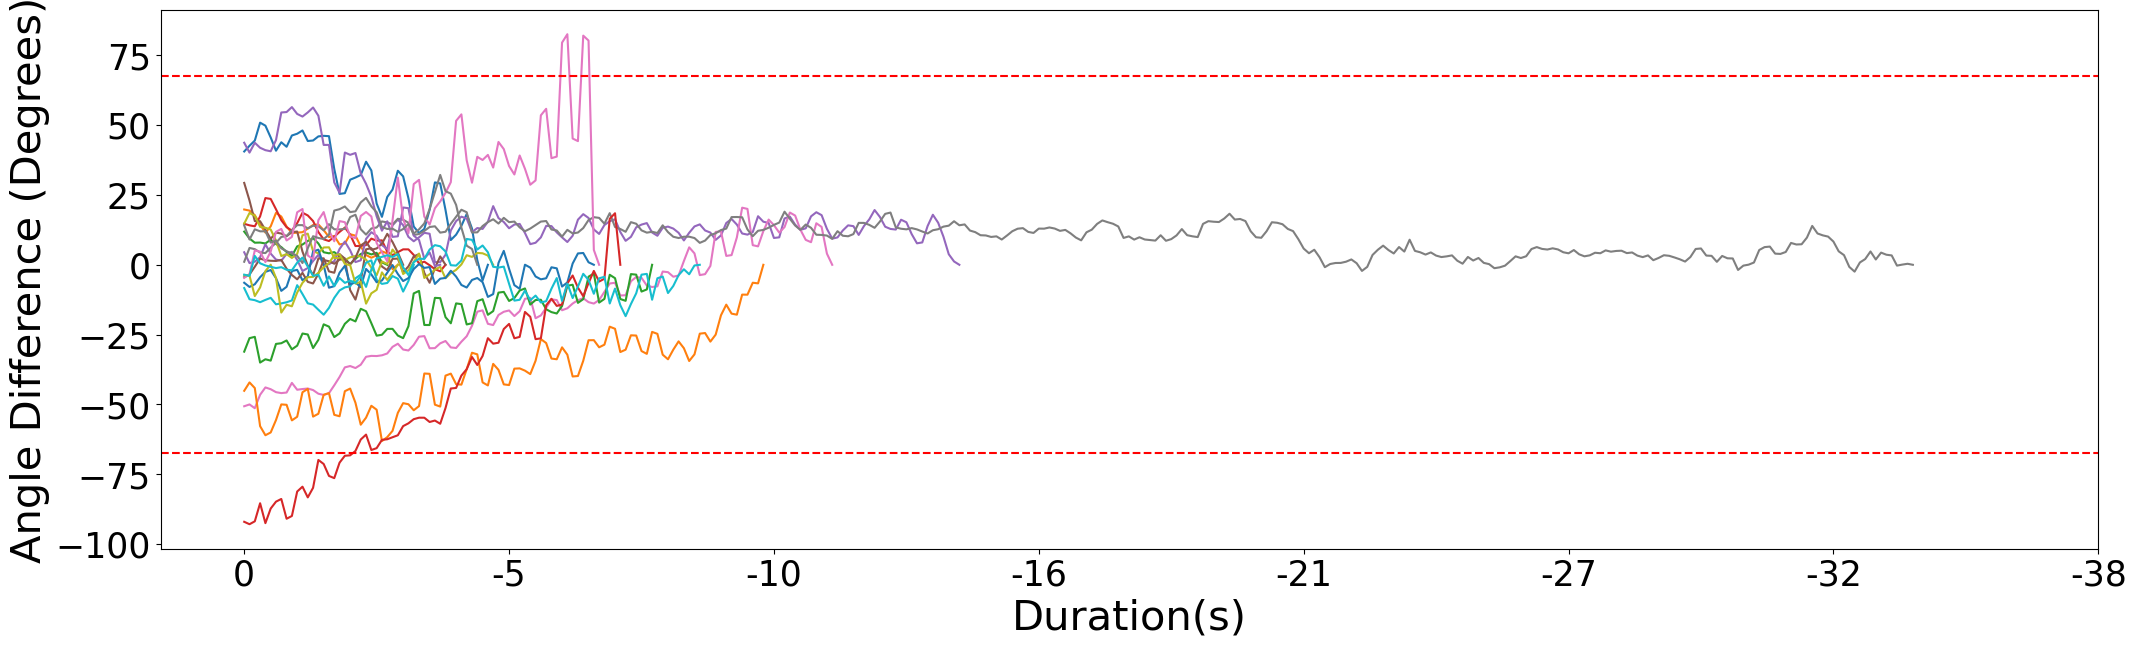

In [53]:
#Plot the reverse of difference during fixed heading period (align at the restart)
plt.figure(figsize= (25,7))
for i in range(len(difference_during_stop)):
    plt.plot(np.flip(difference_during_stop[i]))
             
max_length = 0
for i in range(len(difference_during_stop)):
    if max_length < len(difference_during_stop[i]):
        max_length = len(difference_during_stop[i])

time_array_PVA_difference_stop = np.arange(max_length)/volume_rate
plt.axhline(y= 67.5, color = 'r',linestyle ='--')
plt.axhline(y= -67.5, color = 'r',linestyle ='--')
plt.ylabel('Angle Difference (Degrees)', fontsize=30)
plt.xlabel('Duration(s)',fontsize =30)
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/-volume_rate, dtype=np.int64), fontsize=25)
plt.yticks(fontsize=25)
plt.show()

In [34]:
PVA_angle_at_stop = PVA_during_stopPeriod(stop_index_array = persistence_stop_index_and_length, PVA_array =PVA_Angle_no_series, volume_time=volume_time)
PVA_angle_at_stop.insert(0,'FlyTrial','TQfly201-005')
PVA_angle_at_stop.insert(1,'Genotype','SS00078>sytGCaMP7f')
PVA_angle_at_stop.insert(2,'TrialType','cl')
PVA_angle_at_stop

FlyTrial            Genotype TrialType  Period_duration   
0   TQfly201-005  SS00078>sytGCaMP7f        cl          4.61526  \
1   TQfly201-005  SS00078>sytGCaMP7f        cl          3.40470   
2   TQfly201-005  SS00078>sytGCaMP7f        cl          8.09562   
3   TQfly201-005  SS00078>sytGCaMP7f        cl          6.35544   
4   TQfly201-005  SS00078>sytGCaMP7f        cl         10.36542   
5   TQfly201-005  SS00078>sytGCaMP7f        cl          4.08564   
6   TQfly201-005  SS00078>sytGCaMP7f        cl          6.80940   
7   TQfly201-005  SS00078>sytGCaMP7f        cl          8.70090   
8   TQfly201-005  SS00078>sytGCaMP7f        cl         19.14198   
9   TQfly201-005  SS00078>sytGCaMP7f        cl         12.48390   
10  TQfly201-005  SS00078>sytGCaMP7f        cl         11.04636   
11  TQfly201-005  SS00078>sytGCaMP7f        cl          9.00354   
12  TQfly201-005  SS00078>sytGCaMP7f        cl         17.93142   
13  TQfly201-005  SS00078>sytGCaMP7f        cl          4.84224   
14  TQfly201-005  SS00078>sytGCaMP7f        cl         10.89504   
15  TQfly201-005  SS00078>sytGCaMP7f        cl          5.82582   
16  TQfly201-005  SS00078>sytGCaMP7f        cl          6.05280   

    PVA_before_stop  PVA_at_restart  PVA_100ms_before_restart   
0         -6.020742      -29.890372                -48.540242  \
1          6.129241      -23.373703                -30.094374   
2         60.962251      105.791106                108.017933   
3       -119.773700      -89.261721                -94.520390   
4        177.292411      158.375220                145.777529   
5        142.759655      118.351918                140.055193   
6        -83.766456      -62.856181                -56.397893   
7         82.703546       78.090474                 68.240000   
8        -94.859342     -104.842338               -100.680648   
9         96.678653      102.094962                112.741914   
10       174.891089     -160.290858               -143.580059   
11      -110.170428     -163.788728               -164.186614   
12        87.019387       84.745700                 85.416007   
13        84.854928       61.518373                 97.482089   
14        74.041525       44.447339                 32.642288   
15        69.486347       85.431766                 74.830095   
16        77.515653       14.856683                  8.914206   

    PVA_500ms_before_restart  PVA_in_middle  PVA_2s_before_restart   
0                 -29.359395     -23.653822              -8.906127  \
1                 -51.040038     -18.052960              18.902836   
2                 122.894328      78.306234             112.335722   
3                 -87.530281     -91.107130            -100.970612   
4                 155.978422     162.034496             161.023767   
5                 160.789027      93.988084              93.912942   
6                 -44.141270     -82.461303             -45.242590   
7                  66.601978      86.301032              74.447068   
8                -107.791064     -70.633649             -91.913948   
9                  97.477604     123.567046             105.145267   
10               -161.316527    -177.119170            -160.438987   
11               -146.991200     177.277415            -173.733485   
12                 84.060211      88.617667              87.975345   
13                 80.314680      80.668691              67.192972   
14                 59.074411     117.656430              81.478918   
15                 93.304904     107.922910              91.765309   
16                100.722423      70.655541             126.969391   

    PVA_3s_after_stop  PVA_5s_after_stop  PVA_10s_after_stop   
0           11.919720                NaN                 NaN  \
1          -48.255256                NaN                 NaN   
2           57.055185          89.528894                 NaN   
3         -102.912511         -88.064586                 NaN   
4          165.861376         166.091722         

In [35]:
Forward_speed_at_stop = forwrad_speed_during_stopPeriod(stop_index_array=persistence_stop_index_and_length,forward_speed_array=Forward_speed_degrees, volume_time=volume_time)
Forward_speed_at_stop

forward_speed_before_stop  forward_speed_at_restart   
0                   14.812127                 11.058662  \
1                    0.001416                 10.688127   
2                    2.220896                 30.598665   
3                    0.333337                  4.397538   
4                    1.214657                  6.494692   
5                    1.622162                  0.847953   
6                    2.446714                 14.971904   
7                    1.039553                  0.043083   
8                   17.557677                  1.538993   
9                    2.157646                  7.750826   
10                   5.638996                  9.297120   
11                   1.247896                  1.061772   
12                   1.949081                 17.943386   
13                   3.237975                  1.951369   
14                   0.715191                  2.865012   
15                   4.092558                  1.539497   
16                   0.513148                  1.224137   

    forward_speed_100ms_before_restart  forward_speed_500ms_before_restart   
0                             0.071585                           14.083564  \
1                             4.824380                            2.228930   
2                            15.667408                            7.039344   
3                             2.582616                            5.027801   
4                             4.947682                            0.042911   
5                             1.357648                            0.353141   
6                             7.779202                            9.112610   
7                             0.180421                            1.175672   
8                             8.825776                            1.352879   
9                             3.410244                            0.952658   
10                            2.877975                            7.064662   
11                            0.257621                            1.515946   
12                            4.488387                            4.315827   
13                            4.840228                            7.052309   
14                            0.941580                            5.093291   
15                            0.775521                            2.303441   
16                            0.932627                           17.983870   

    forward_speed_in_middle  forward_speed_2s_before_restart   
0                  1.079377                         0.255177  \
1                  0.165720                         0.758645   
2                  0.493651                         4.182930   
3                  0.251137                         2.182204   
4                  0.308187                         2.086957   
5                  0.882590                         0.363550   
6                  0.192543                         9.244216   
7                  0.880347                         0.754458   
8                  5.257329                         8.386431   
9                  1.909773                         3.300591   
10                 3.830026                         5.144057   
11                 3.042683                         0.049825   
12                 0.887902                         4.427541   
13                 2.417028                         1.873705   
14                 2.361106                         8.369323   
15                 0.300051                         3.155510   
16                 6.673603                         2.245708   

    forward_speed_3s_after_stop  forward_speed_5s_after_stop   
0                      1.986708                          NaN  \
1                      2.763075                          NaN   
2                      0.655552                     6.022691   
3                      5.647944                     2.863666   
4                      0.920493                     1.614714   

In [36]:
Bump_amplitude_at_stop = bump_amplitude_during_stopPeriod(stop_index_array=persistence_stop_index_and_length,bump_amplitude_array=Bump_amplitude_no_series, volume_time=volume_time)
Bump_amplitude_at_stop

bump_amplitude_before_stop  bump_amplitude_at_restart   
0                     0.317252                   0.243872  \
1                     0.308538                   0.795988   
2                     0.922926                   0.418957   
3                     1.023978                   0.693776   
4                     0.544694                   0.275350   
5                     0.297756                   0.189138   
6                     0.691355                   0.577395   
7                     0.872137                   0.634283   
8                     0.806474                   0.259349   
9                     0.561381                   0.626701   
10                    1.114401                   0.248877   
11                    0.167239                   0.290119   
12                    1.192617                   0.883408   
13                    0.323278                   0.150373   
14                    0.183594                   0.308129   
15                    0.219907                   0.253963   
16                    0.102722                   0.306956   

    bump_amplitude_100ms_before_restart  bump_amplitude_500ms_before_restart   
0                              0.218836                             0.313897  \
1                              0.624845                             0.506077   
2                              0.398703                             0.559583   
3                              0.641426                             0.653121   
4                              0.479231                             0.430831   
5                              0.222738                             0.169013   
6                              0.636473                             0.542638   
7                              0.815217                             0.751796   
8                              0.241160                             0.234205   
9                              0.605443                             0.588231   
10                             0.296719                             0.343809   
11                             0.290930                             0.279125   
12                             0.905153                             0.669890   
13                             0.134752                             0.241827   
14                             0.346946                             0.368600   
15                             0.327921                             0.261384   
16                             0.312458                             0.192337   

    bump_amplitude_in_middle  bump_amplitude_2s_before_restart   
0                   0.341788                          0.146179  \
1                   0.373484                          0.527577   
2                   0.472154                          0.511172   
3                   0.755735                          0.813192   
4                   0.668643                          0.368432   
5                   0.193959                          0.211399   
6                   0.605409                          0.452727   
7                   0.631026                          0.579391   
8                   0.239613                          0.366100   
9                   0.687850                          0.513176   
10                  0.627045                          0.517569   
11                  0.449395                          0.345373   
12                  0.621553                          0.596144   
13                  0.323666                          0.285051   
14                  0.142199                          0.056567   
15                  0.333710                          0.267054   
16                  0.137685                          0.154333   

    bump_amplitude_3s_after_stop  bump_amplitude_5s_after_stop   
0                       0.303862                           NaN  \
1                       0.579056                           NaN   
2                       0.546993                      0.354329   
3          

In [37]:
output_df = pd.concat([PVA_angle_at_stop,Forward_speed_at_stop,Bump_amplitude_at_stop], axis=1)
output_df

FlyTrial            Genotype TrialType  Period_duration   
0   TQfly201-005  SS00078>sytGCaMP7f        cl          4.61526  \
1   TQfly201-005  SS00078>sytGCaMP7f        cl          3.40470   
2   TQfly201-005  SS00078>sytGCaMP7f        cl          8.09562   
3   TQfly201-005  SS00078>sytGCaMP7f        cl          6.35544   
4   TQfly201-005  SS00078>sytGCaMP7f        cl         10.36542   
5   TQfly201-005  SS00078>sytGCaMP7f        cl          4.08564   
6   TQfly201-005  SS00078>sytGCaMP7f        cl          6.80940   
7   TQfly201-005  SS00078>sytGCaMP7f        cl          8.70090   
8   TQfly201-005  SS00078>sytGCaMP7f        cl         19.14198   
9   TQfly201-005  SS00078>sytGCaMP7f        cl         12.48390   
10  TQfly201-005  SS00078>sytGCaMP7f        cl         11.04636   
11  TQfly201-005  SS00078>sytGCaMP7f        cl          9.00354   
12  TQfly201-005  SS00078>sytGCaMP7f        cl         17.93142   
13  TQfly201-005  SS00078>sytGCaMP7f        cl          4.84224   
14  TQfly201-005  SS00078>sytGCaMP7f        cl         10.89504   
15  TQfly201-005  SS00078>sytGCaMP7f        cl          5.82582   
16  TQfly201-005  SS00078>sytGCaMP7f        cl          6.05280   

    PVA_before_stop  PVA_at_restart  PVA_100ms_before_restart   
0         -6.020742      -29.890372                -48.540242  \
1          6.129241      -23.373703                -30.094374   
2         60.962251      105.791106                108.017933   
3       -119.773700      -89.261721                -94.520390   
4        177.292411      158.375220                145.777529   
5        142.759655      118.351918                140.055193   
6        -83.766456      -62.856181                -56.397893   
7         82.703546       78.090474                 68.240000   
8        -94.859342     -104.842338               -100.680648   
9         96.678653      102.094962                112.741914   
10       174.891089     -160.290858               -143.580059   
11      -110.170428     -163.788728               -164.186614   
12        87.019387       84.745700                 85.416007   
13        84.854928       61.518373                 97.482089   
14        74.041525       44.447339                 32.642288   
15        69.486347       85.431766                 74.830095   
16        77.515653       14.856683                  8.914206   

    PVA_500ms_before_restart  PVA_in_middle  PVA_2s_before_restart  ...   
0                 -29.359395     -23.653822              -8.906127  ...  \
1                 -51.040038     -18.052960              18.902836  ...   
2                 122.894328      78.306234             112.335722  ...   
3                 -87.530281     -91.107130            -100.970612  ...   
4                 155.978422     162.034496             161.023767  ...   
5                 160.789027      93.988084              93.912942  ...   
6                 -44.141270     -82.461303             -45.242590  ...   
7                  66.601978      86.301032              74.447068  ...   
8                -107.791064     -70.633649             -91.913948  ...   
9                  97.477604     123.567046             105.145267  ...   
10               -161.316527    -177.119170            -160.438987  ...   
11               -146.991200     177.277415            -173.733485  ...   
12                 84.060211      88.617667              87.975345  ...   
13                 80.314680      80.668691              67.192972  ...   
14                 59.074411     117.656430              81.478918  ...   
15                 93.304904     107.922910              91.765309  ...   
16                100.722423      70.655541             126.969391  ...   

    bump_amplitude_at_restart  bump_amplitude_100ms_before_restart   
0                    0.243872                             0.218836  \
1                    0.795988                             0.624845   
2                    0.418957                             0.398703   

In [38]:
if trial_type == 1:
    output_df.to_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/fixed_heading_period_data/points_during_stop_period/cl trial/cl_Ca_imaging/PFNd/PFNd_FB(syt)/TQfly201-005-Fixed_Heading_Period.csv',encoding = 'utf-8', index=False)
else:
     output_df.to_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/fixed_heading_period_data/points_during_stop_period/dark trial/dark_Ca_imaging/PFNd/PFNd_FB(syt)/TQfly201-004-Fixed_Heading_Period.csv',encoding = 'utf-8', index=False)

In [39]:
#Combine all persistence files for pooled analysis and statistics 

pooled_directory = ('/home/tianhaoqiu/Documents/GitHub/2p_analysis/fixed_heading_period_data/points_during_stop_period/cl trial/cl_Ca_imaging/PFNd/PFNd_FB(syt)')
pooled_file_list = []
count = 0
for single_df in os.listdir(pooled_directory):
    if count == 0:
        persistence_data_pooled = pd.read_csv(sep.join([pooled_directory, single_df]))
        count = count + 1
    else:
        current_df = pd.read_csv(sep.join([pooled_directory, single_df]))
        persistence_data_pooled = pd.concat([persistence_data_pooled,current_df], ignore_index=True)
        count = count + 1

persistence_data_pooled
        

FlyTrial            Genotype TrialType  Period_duration   
0    TQfly196-005  SS00078>sytGCaMP7f        cl         12.37356  \
1    TQfly196-005  SS00078>sytGCaMP7f        cl          5.07870   
2    TQfly196-005  SS00078>sytGCaMP7f        cl          3.32424   
3    TQfly196-005  SS00078>sytGCaMP7f        cl         31.21092   
4    TQfly196-005  SS00078>sytGCaMP7f        cl         23.54670   
..            ...                 ...       ...              ...   
265  TQfly198-003  SS00078>sytGCaMP7f        cl          6.43997   
266  TQfly198-003  SS00078>sytGCaMP7f        cl          4.88817   
267  TQfly198-003  SS00078>sytGCaMP7f        cl          6.05202   
268  TQfly198-003  SS00078>sytGCaMP7f        cl          9.15562   
269  TQfly198-003  SS00078>sytGCaMP7f        cl         14.12138   

     PVA_before_stop  PVA_at_restart  PVA_100ms_before_restart   
0        -109.722261      -90.163008                -88.820695  \
1         -95.451878     -114.383711               -125.337034   
2         -79.345661      -18.071771                  8.013434   
3          82.988082      112.713127                 45.572348   
4         -47.668074      -53.334944                -71.322385   
..               ...             ...                       ...   
265       -69.584526     -100.316954                -90.999907   
266       -78.994109      -63.221285                -69.475957   
267       -62.326833     -109.210682               -108.863911   
268       -91.792840      -81.692009                -72.504681   
269       -93.402758      120.581537                117.920110   

     PVA_500ms_before_restart  PVA_in_middle  PVA_2s_before_restart  ...   
0                  -64.283543    -115.100079            -113.071654  ...  \
1                 -126.881362     -83.366787             -85.876127  ...   
2                  -99.885194    -103.369052             -61.962186  ...   
3                  127.550329      96.415523              96.711746  ...   
4                  -67.706505     -59.095326             -82.384381  ...   
..                        ...            ...                    ...  ...   
265                -97.407464     -60.172970             -88.578017  ...   
266                -57.107418     -91.300454             -70.691761  ...   
267                -99.309645    -105.255805            -120.685805  ...   
268                -60.867541     -72.776903             -78.390635  ...   
269                114.345022     113.535918             140.834314  ...   

     bump_amplitude_at_restart  bump_amplitude_100ms_before_restart   
0                     0.210133                             0.191051  \
1                     0.460890                             0.549897   
2                     0.124345                             0.154527   
3                     0.410790                             0.388758   
4                     0.339728                             0.353735   
..                         ...                                  ...   
265                   0.523714                             0.593610   
266                   0.323698                             0.223642   
267                   0.588485                             0.591057   
268                   0.374095                             0.280109   
269                   0.228908                             0.208910   

     bump_amplitude_500ms_before_restart  bump_amplitude_in_middle   
0                               0.207249                  0.248954  \
1                               0.800938                  0.825327   
2                               0.152192                  0.173606   
3                               0.224482                  0.117062   
4                               0.198095                  0.291965   
..                                   ...                       ...   
265                             0.668724                  0.456003   
266                             0.217847                  0.265500   
267

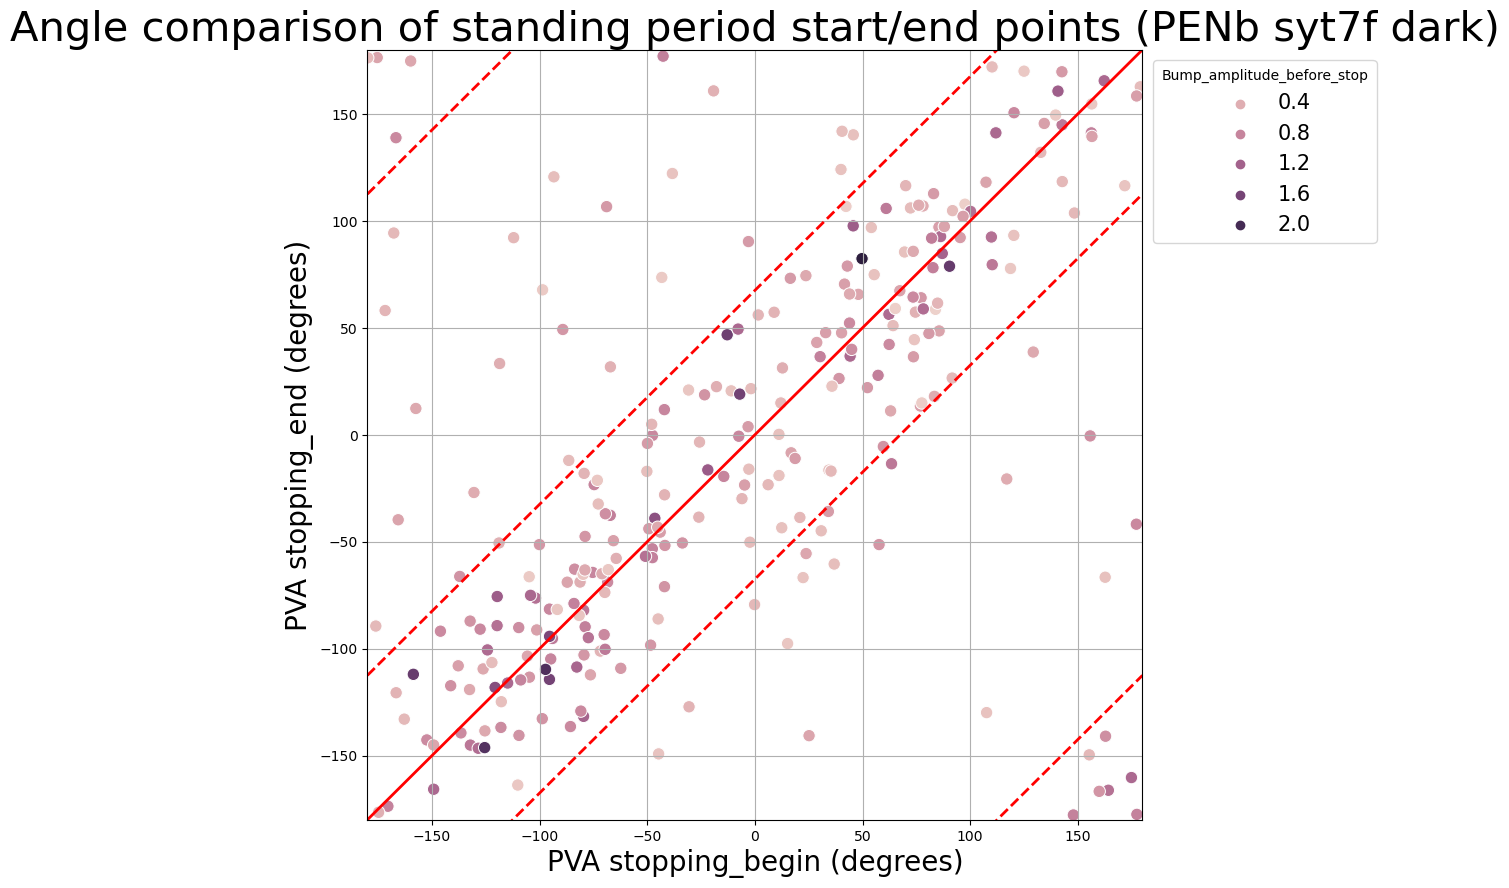

In [40]:
plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = persistence_data_pooled, x='PVA_before_stop', y='PVA_at_restart', hue = 'bump_amplitude_before_stop',s =80)
snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump_amplitude_before_stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='r', linewidth =2)
plt.plot(X_plot,Y_plot + 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot + 292.5, color= 'r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 292.5, color='r', linestyle ='--', linewidth =2)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Angle comparison of standing period start/end points (PENb syt7f dark)', fontsize =30)
plt.ylabel('PVA stopping_end (degrees)',fontsize= 20)
plt.xlabel('PVA stopping_begin (degrees)',fontsize= 20)
#plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
plt.grid()
plt.show()

In [41]:
## Pilot code for boot stramping paired angle difference between start and end of the stopping period

#initialize a bootstrap array
bootstrap_mean_angle_differences_10000 = np.zeros(10000)
#size of each sampling 
pair_num = len(persistence_data_pooled['PVA_before_stop'])

for i in range(len(bootstrap_mean_angle_differences_10000)):
    random_stop_start_angle = np.random.choice(persistence_data_pooled['PVA_before_stop'],size = pair_num)
    random_stop_end_angle = np.random.choice(persistence_data_pooled['PVA_at_restart'],size = pair_num)
    angle_difference = calculate_angle_difference_between_two_time_point(random_stop_start_angle,random_stop_end_angle)
    bootstrap_mean_angle_differences_10000[i] = np.mean(np.abs(angle_difference))    

In [42]:
actual_angle_diff = calculate_angle_difference_between_two_time_point(persistence_data_pooled['PVA_before_stop'],persistence_data_pooled['PVA_at_restart'])
actual_mean_absolute_angle_diff = np.mean(np.abs(actual_angle_diff))
actual_mean_absolute_angle_diff 

38.97110482902735

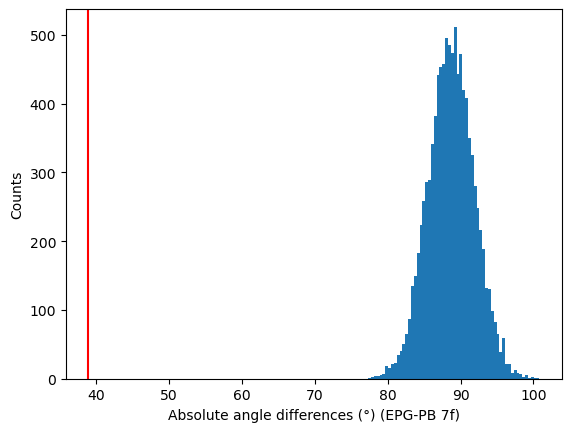

In [43]:
plt.hist(bootstrap_mean_angle_differences_10000 ,bins='auto')
plt.axvline(x = actual_mean_absolute_angle_diff, color = 'r')
plt.xlabel('Absolute angle differences (°) (EPG-PB 7f)')
plt.ylabel('Counts')
plt.show()

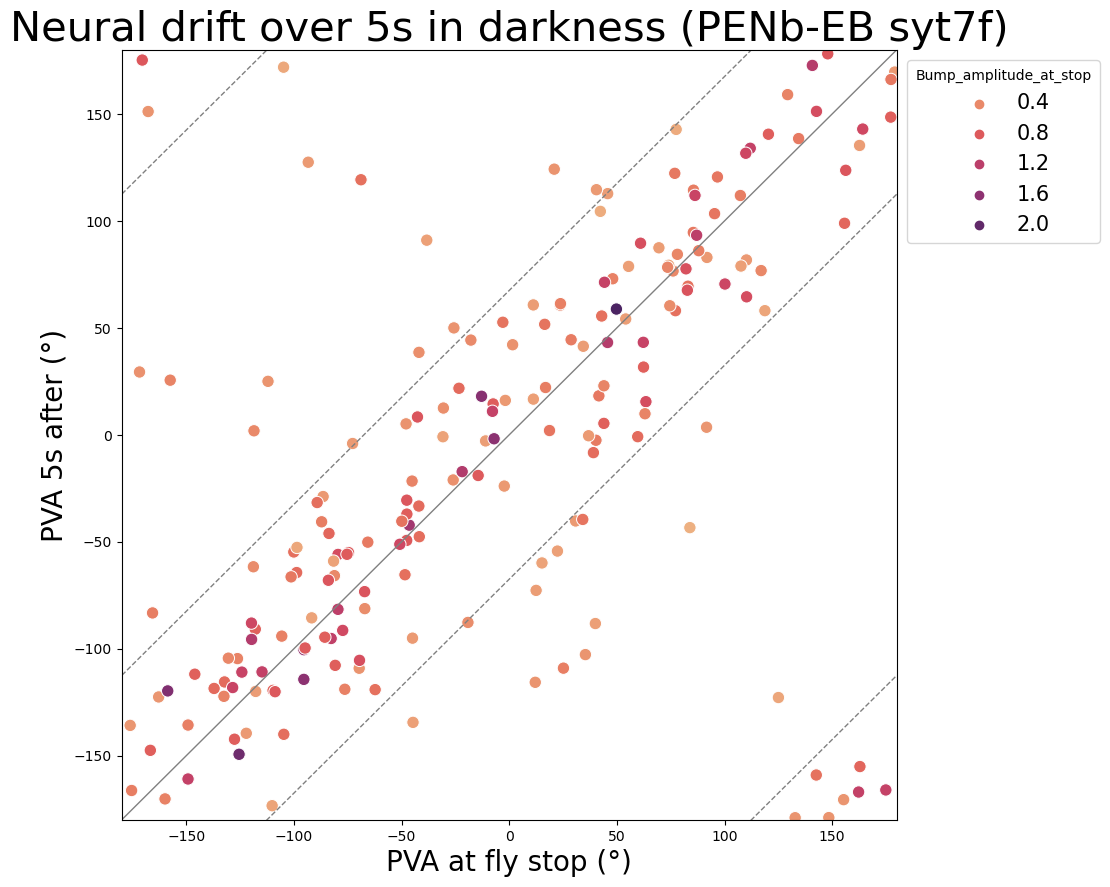

In [44]:
plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = persistence_data_pooled, x='PVA_before_stop', y='PVA_5s_after_stop', palette = 'flare',hue = 'bump_amplitude_before_stop',s =80)
snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump_amplitude_at_stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='grey', linewidth =1)
plt.plot(X_plot,Y_plot + 67.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot - 67.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot + 292.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot - 292.5, color='grey', linestyle ='--', linewidth =1)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Neural drift over 5s in darkness (PENb-EB syt7f)', fontsize =30)
plt.ylabel('PVA 5s after (°)',fontsize= 20)
plt.xlabel('PVA at fly stop (°)',fontsize= 20)
#plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
plt.show()

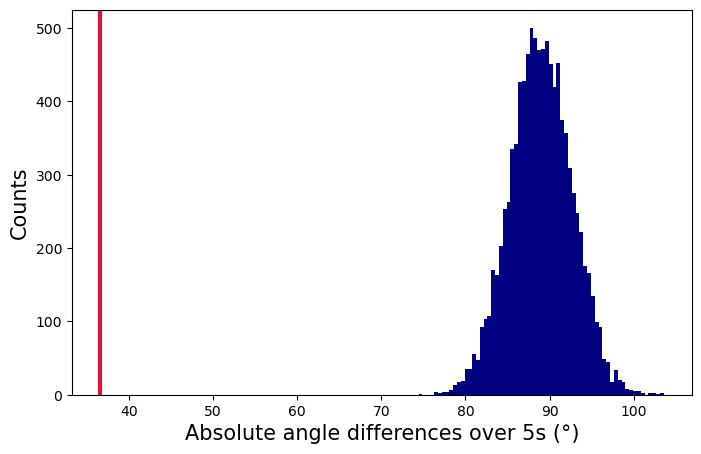

In [45]:
stop_period_start_5s = np.zeros(len(np.argwhere(np.isnan(persistence_data_pooled['PVA_5s_after_stop'])==0)))
stop_period_end_5s = np.zeros(len(np.argwhere(np.isnan(persistence_data_pooled['PVA_5s_after_stop'])==0))) 
long_trial_index = np.argwhere(np.isnan(persistence_data_pooled['PVA_5s_after_stop'])==0)
for i in range(len(stop_period_start_5s )):
    stop_period_start_5s[i] = persistence_data_pooled['PVA_before_stop'][long_trial_index[i][0]]
    stop_period_end_5s[i] =  persistence_data_pooled['PVA_5s_after_stop'][long_trial_index[i][0]]
## Pilot code for boot stramping paired angle difference between start and end of the stopping period

#initialize a bootstrap array
bootstrap_mean_angle_differences_10000 = np.zeros(10000)
#size of each sampling 
pair_num = len(stop_period_start_5s)

for i in range(len(bootstrap_mean_angle_differences_10000)):
    random_stop_start_angle = np.random.choice(stop_period_start_5s,size = pair_num)
    random_stop_end_angle = np.random.choice(stop_period_end_5s,size = pair_num)
    angle_difference = calculate_angle_difference_between_two_time_point(random_stop_start_angle,random_stop_end_angle)
    bootstrap_mean_angle_differences_10000[i] = np.mean(np.abs(angle_difference))   

actual_mean_absolute_angle_diff_diff_5s =  calculate_angle_difference_between_two_time_point(stop_period_start_5s ,stop_period_end_5s)
actual_mean_absolute_angle_diff_5s = np.mean(np.abs(actual_mean_absolute_angle_diff_diff_5s))
actual_mean_absolute_angle_diff_5s     

plt.figure(figsize= (8,5))
plt.hist(bootstrap_mean_angle_differences_10000 ,bins='auto', color = 'navy')
plt.axvline(x = actual_mean_absolute_angle_diff_5s, color = 'crimson',linewidth =3)
plt.xlabel('Absolute angle differences over 5s (°)',fontsize= 15)
plt.ylabel('Counts',fontsize= 15)
plt.show()   

In [46]:
actual_mean_absolute_angle_diff_5s

36.59827270649015

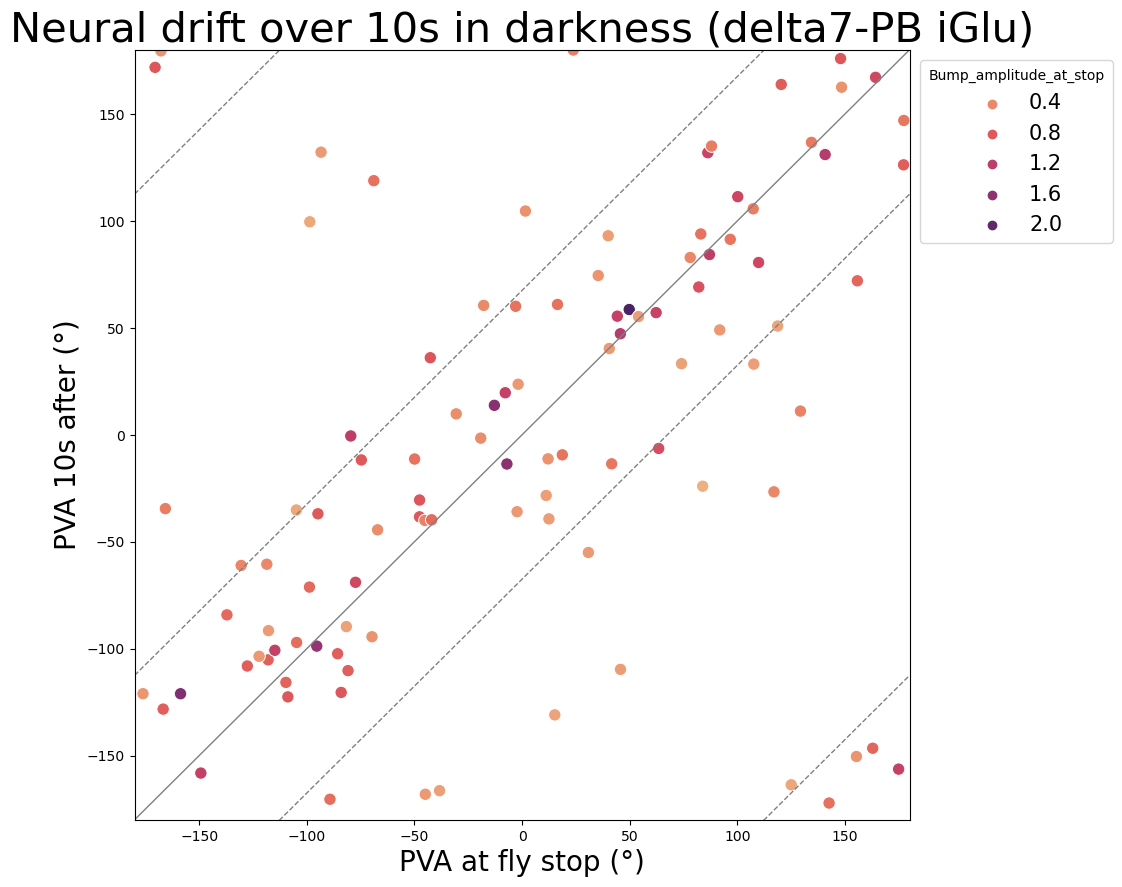

In [47]:
a = plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = persistence_data_pooled, x='PVA_before_stop', y='PVA_10s_after_stop', palette = 'flare',hue = 'bump_amplitude_before_stop', s =80)
snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump_amplitude_at_stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='grey', linewidth =1)
plt.plot(X_plot,Y_plot + 67.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot - 67.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot + 292.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot - 292.5, color='grey', linestyle ='--', linewidth =1)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Neural drift over 10s in darkness (delta7-PB iGlu)', fontsize =30)
plt.ylabel('PVA 10s after (°)',fontsize= 20)
plt.xlabel('PVA at fly stop (°)',fontsize= 20)
#plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
plt.show()
#a.savefig('E-PG_Bump_Angle_10s_after_cl', format ='svg')

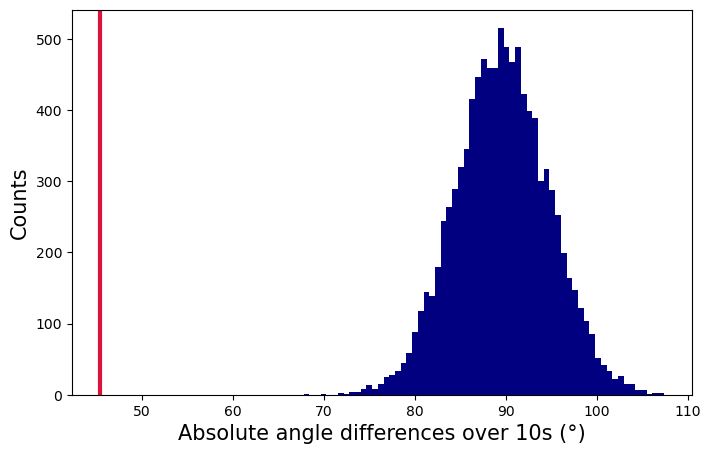

In [48]:
stop_period_start_10s = np.zeros(len(np.argwhere(np.isnan(persistence_data_pooled['PVA_10s_after_stop'])==0)))
stop_period_end_10s = np.zeros(len(np.argwhere(np.isnan(persistence_data_pooled['PVA_10s_after_stop'])==0))) 
long_trial_index = np.argwhere(np.isnan(persistence_data_pooled['PVA_10s_after_stop'])==0)
for i in range(len(stop_period_start_10s )):
    stop_period_start_10s[i] = persistence_data_pooled['PVA_before_stop'][long_trial_index[i][0]]
    stop_period_end_10s[i] =  persistence_data_pooled['PVA_10s_after_stop'][long_trial_index[i][0]]
## Pilot code for boot stramping paired angle difference between start and end of the stopping period

#initialize a bootstrap array
bootstrap_mean_angle_differences_10000 = np.zeros(10000)
#size of each sampling 
pair_num = len(stop_period_start_10s)

for i in range(len(bootstrap_mean_angle_differences_10000)):
    random_stop_start_angle = np.random.choice(stop_period_start_10s,size = pair_num)
    random_stop_end_angle = np.random.choice(stop_period_end_10s,size = pair_num)
    angle_difference = calculate_angle_difference_between_two_time_point(random_stop_start_angle,random_stop_end_angle)
    bootstrap_mean_angle_differences_10000[i] = np.mean(np.abs(angle_difference))   

actual_mean_absolute_angle_diff_diff_10s =  calculate_angle_difference_between_two_time_point(stop_period_start_10s ,stop_period_end_10s)
actual_mean_absolute_angle_diff_10s = np.mean(np.abs(actual_mean_absolute_angle_diff_diff_10s))
actual_mean_absolute_angle_diff_10s     

plt.figure(figsize= (8,5))
plt.hist(bootstrap_mean_angle_differences_10000 ,bins='auto',color = 'navy')
plt.axvline(x = actual_mean_absolute_angle_diff_10s, color = 'crimson',linewidth =3)
plt.xlabel('Absolute angle differences over 10s (°)',fontsize= 15)
plt.ylabel('Counts',fontsize= 15)
plt.show()

In [49]:
np.quantile(bootstrap_mean_angle_differences_10000,0.000000000001)

67.8012133839728

In [50]:
len(long_trial_index)

103

In [51]:
actual_mean_absolute_angle_diff_10s    

45.44480972144053

In [52]:
#from scipy.stats import ranksums
#ranksums(np.abs(actual_mean_absolute_angle_diff_dark_diff), np.abs(actual_mean_absolute_angle_diff_cl_diff))

In [167]:
stats.mannwhitneyu(np.abs(actual_mean_absolute_angle_diff_dark_diff), np.abs(actual_mean_absolute_angle_diff_cl_diff), alternative = 'two-sided')

MannwhitneyuResult(statistic=3465.0, pvalue=0.0296191376401522)

In [173]:
np.savetxt('angle_difference_cl_10s.csv', np.abs(actual_mean_absolute_angle_diff_cl_diff))

In [56]:
persistence_data_pooled['angle difference start/middle'] = calculate_angle_difference_between_two_time_point(persistence_data_pooled['PVA_before_stop'],persistence_data_pooled['PVA_in_middle'])

In [57]:
persistence_data_pooled['angle difference start/end'] = calculate_angle_difference_between_two_time_point(persistence_data_pooled['PVA_before_stop'],persistence_data_pooled['PVA_at_restart'])

In [58]:
persistence_data_pooled

FlyTrial        Genotype TrialType  Period_duration  PVA_before_stop   
0    TQfly020-004  R60D05>GCaMP7f        cl          8.63612       152.779284  \
1    TQfly020-004  R60D05>GCaMP7f        cl          4.31806       -86.439229   
2    TQfly020-004  R60D05>GCaMP7f        cl         37.35624       -85.523872   
3    TQfly020-004  R60D05>GCaMP7f        cl          5.92478        -1.320021   
4    TQfly020-004  R60D05>GCaMP7f        cl          6.92898       104.161500   
..            ...             ...       ...              ...              ...   
144  TQfly006-004  R60D05>GCaMP7f        cl         20.02497       -42.736785   
145  TQfly006-004  R60D05>GCaMP7f        cl         23.74218       138.222288   
146  TQfly006-004  R60D05>GCaMP7f        cl         15.58830      -142.700005   
147  TQfly006-004  R60D05>GCaMP7f        cl         13.07019      -131.178308   
148  TQfly006-004  R60D05>GCaMP7f        cl         88.01394       149.353316   

     PVA_at_restart  PVA_100ms_before_restart  PVA_500ms_before_restart   
0        129.954677                156.596466                 16.232703  \
1        -68.797495                -74.962955                -69.155067   
2        -64.215069                -65.600353                -34.962486   
3         32.400089                 40.185377                 39.926749   
4        103.727001                105.218979                104.758681   
..              ...                       ...                       ...   
144      -77.586427                -48.538572                -72.358036   
145     -163.702983               -173.821122               -166.495025   
146     -149.362476               -157.569945                -99.942970   
147     -150.006876               -143.112831                177.899859   
148     -118.466666                 55.608811                 50.969139   

     PVA_in_middle  PVA_2s_before_restart  ...  bump_amplitude_at_restart   
0      -157.673166             113.858629  ...                   0.120168  \
1       -55.013859             -65.503918  ...                   0.494114   
2       -24.163843             -84.568892  ...                   0.124029   
3        43.955119              66.408276  ...                   0.502485   
4        96.081117              99.294985  ...                   0.958967   
..             ...                    ...  ...                        ...   
144    -132.141746            -100.250723  ...                   0.254206   
145    -165.264493             142.279049  ...                   0.238209   
146    -120.791635             162.518259  ...                   0.301008   
147    -127.937979            -165.489649  ...                   0.240625   
148      19.296692              47.018918  ...                   0.105966   

     bump_amplitude_100ms_before_restart  bump_amplitude_500ms_before_restart   
0                               0.118655                             0.180550  \
1                               0.514409                             0.639346   
2                               0.107755                             0.185554   
3                               0.438824                             0.672808   
4                               1.017992                             1.064665   
..                                   ...                                  ...   
144                             0.227604                             0.197644   
145                             0.248334                             0.241640   
146                             0.278209                             0.304520   
147                             0.240952                             0.214188   
148                             0.220290                             0.319481   

     bump_amplitude_in_middle  bump_amplitude_2s_before_restart   
0                    0.139993                          0.102664  \
1                    0.587214                          0.447535   
2                    0.201707       

In [59]:
persistence_data_pooled.to_csv('/home/tianhaoqiu/Documents/persistence_data_pooled_EPG_7f_PB_cl.csv',encoding = 'utf-8', index=False)